<a href="https://colab.research.google.com/github/Himanshucode77/Case_Study/blob/main/LoanTap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brief Summary**

LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

Personal Loan
EMI Free Loan
Personal Overdraft
Advance Salary Loan

# **Problem Statement**


The goal is to determine if a credit line should be extended to a business, given a set of attributes for an MSME/ Individual. If so, what should the repayment terms be in business recommendations?

# **Importing required packages**

In [ ]:
 ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip (22.0 MB)


In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import warnings
import random
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings("ignore")

# **Common Utilities**

In [ ]:
fontsize, fontfamily, fontweight = 12, "Comic Sans MS", "bold"
palette_color = sns.color_palette("ch:s=.25, rot=-.25")

In [ ]:
def missingValue(df):
    total_null = df.isnull().sum().sort_values(ascending = False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending = False)
    print("Total records = ", df.shape[0])

    tab = pd.concat([total_null,percent.round(2)],axis=1,keys=['Total Missing','In Percent'])
    return tab

In [ ]:
def detectoutlier(df,colname):
    Q3 = df[colname].quantile(0.75)
    Q1 = df[colname].quantile(0.25)
    IQR = Q3-Q1
    outlier_left = Q1 - (1.5 * IQR)
    outlier_right = Q3 + (1.5 * IQR)

    return df[(df[colname]<= outlier_left) | (df[colname] >= outlier_right)]

In [ ]:
def removeoutlier(df,colname):
    Q3 = df[colname].quantile(0.75)
    Q1 = df[colname].quantile(0.25)
    IQR = Q3-Q1
    outlier_left = Q1 - (1.5 * IQR)
    outlier_right = Q3 + (1.5 * IQR)

    return df[(df[colname]> outlier_left) & (df[colname] < outlier_right)]

In [ ]:
def getoutlier_per(df, cols):
    Q3 = df[cols].quantile(0.75)
    Q1 = df[cols].quantile(0.25)
    IQR = Q3-Q1
    outlier_left = Q1 - (1.5 * IQR)
    outlier_right = Q3 + (1.5 * IQR)

    df_tmp = df[~((df[numerical_cols]<= outlier_left) | (df[numerical_cols]>= outlier_right)).any(axis = 1)]
    df_tmp = df_tmp.reset_index(drop = True)
    return df_tmp.shape[0]
    
    #perc = (df.shape[0] -  df_tmp.shape[0]/df.shape[0])*100
    #return perc

In [ ]:
def feature_names(df):
    print(f"Categorical Features are : \
    {list(df.select_dtypes('object').columns)}")
    #print('-'*100)
    #print('-'*100)
    print(f"Numerical Features are: \
    {list(df.select_dtypes(['int64','float64']).columns)}")

In [ ]:
def kdeplot(df, colname, title, axis, test = False):
    g = sns.kdeplot(df[colname], ax = axis)
    axis.axvline(df[colname].mean(), color = "r", linestyle = "--", label = "Mean")
    if (title):
      axis.set_title(title, fontweight = fontweight)
    g.set(yticklabels=[])
    g.set(ylabel=None)
    if (not test):
      axis.axvline(df[colname].median(), color = "g", linestyle = "-", label = "Median")
    else:
      axis.legend({ "Mean" : df[colname].mean(), "Median" : df[colname].median() })

In [ ]:
def barplottwocol(df, xcolname, ycolname, axis, rotate, hcolname = None):
    sns.barplot(data = df, x = xcolname, y = ycolname, hue = hcolname, ax = axis)
    axis.set_title(xcolname + " | " + ycolname, fontweight = fontweight)
    if (rotate): axis.set_xticklabels(axis.get_xticklabels(), rotation = 90)
    axis.set_xlabel(None) 
    axis.set_ylabel(None) 

In [ ]:
def distplot(df,colname,title,axis):
    axis.set_title(title, fontweight="bold")
    sns.distplot(df[colname],ax=axis)
    axis.axvline(df[colname].mean(), color='r', linestyle='--', label="Mean")
    axis.axvline(df[colname].median(), color='g', linestyle='-', label="Median")
    axis.axvline(df[colname].mode()[0], color='m', linestyle='-', label="Mode")
    axis.legend({'Mean':df[colname].mean(),'Median':df[colname].median(),'Mode':df[colname].mode()})

In [ ]:
def boxplot(df,colname,title,axis):
    axis.set_title(title, fontweight="bold")
    plt.ylabel(colname, fontsize=12,family = "Comic Sans MS")
    sns.boxplot(y = df[colname],ax=axis)

In [ ]:
def barplot(df,colname,axis):
    xlbl = colname
    ylbl = "Frequency of " + colname + " (%)"
    palette_color = sns.color_palette("ch:s=.25,rot=-.25")
    df_count = df[colname].value_counts()
    df_count.plot.bar(color=palette_color,ax=axis)
    axis.set_xlabel(xlbl) 
    axis.set_ylabel(ylbl) 

In [ ]:
def countplot(df, xcolname, hcolname, axis):
    title = xcolname + " - " + hcolname + " based distribution"
    sns.countplot(data=df,x=xcolname, hue=hcolname, palette="Set2",ax=axis)
    axis.set_title(title,fontweight="bold")
    axis.set_xlabel(xcolname)  
    axis.set_ylabel('count')

In [ ]:
def pointplot(df,colname1,colname2,colname3,title,axis):
    sns.pointplot(x=df[colname1],y=df[colname2],hue=df[colname3],ax=axis) 
    axis.set_xlabel(colname1) 
    axis.set_ylabel(colname2)
    axis.set_title(title,fontweight="bold")

In [ ]:
def pieplot(df,colname,axis):
    palette_color = sns.color_palette("ch:s=.25,rot=-.25")
    df_count = df[colname].value_counts()
    df_count.plot.pie(colors = palette_color,autopct='%.0f%%',ax=axis)  

In [ ]:
def boxplot_bicol(df,colname1, colname2,axis):    
    sns.boxplot(x = colname1,y = colname2, data = df,ax=axis,palette="Paired")
    axis.set_xlabel(colname1, fontweight="bold",fontsize=14,family = "Comic Sans MS")
    axis.set_ylabel(colname2, fontweight="bold", fontsize=14,family = "Comic Sans MS")

In [ ]:
def scatterplot(df, xcolname, ycolname, title, axis):   
    sns.scatterplot(data = df, x = xcolname, y = ycolname, ax = axis)
    axis.set_title(title, fontweight = fontweight)
    axis.set_xlabel(None) 
    axis.set_ylabel(None)

In [ ]:
def scatterplotonecol(df, xcolname, title, axis):   
    g = sns.scatterplot(data = df[xcolname], ax = axis)
    if (title):
      axis.set_title(title, fontweight = fontweight)
    g.set(xticklabels=[])
    g.set(xlabel=None)

In [ ]:
def pointplot(df,colname1,colname2,colname3,title,axis):
    sns.pointplot(x=df[colname1],y=df[colname2],hue=df[colname3],ax=axis) 
    axis.set_xlabel(colname1) 
    axis.set_ylabel(colname2)
    axis.set_title(title,fontweight="bold")

In [ ]:
def histplot(df,title,axis):
    sns.histplot(df, bins = 50, kde = True, ax = axis)
    axis.set_title(title,fontweight="bold")

In [ ]:
def histplot_log(df,title,axis):
    sns.histplot(np.log(df['count']), bins = 50, kde = True, ax = axis)
    axis.set_title(title,fontweight="bold")

In [ ]:
def qqplot(df,title,axis):
    sm.qqplot(df, line = 's', ax = axis)
    axis.set_title(title)

In [ ]:
def qqplot_log(df,title,axis):
    sm.qqplot(np.log(df), line = 's', ax = axis)
    axis.set_title(title)

In [ ]:
def violinplot(df, xcolname, ycolname, axis, rotate, hcolname = None):
    sns.violinplot(data = df, x = xcolname, y = ycolname, hue = hcolname, ax = axis)
    axis.set_title(xcolname + " | " + ycolname, fontweight = fontweight)
    if (rotate): axis.set_xticklabels(axis.get_xticklabels(), rotation = 90)
    axis.set_xlabel(None) 
    axis.set_ylabel(None) 

In [ ]:
def lineplot(df, xcolname, ycolname, hcolname, title, axis):
    if (hcolname): 
      title = title + " | " + hcolname
      sns.lineplot(data = df, x = xcolname, y = ycolname, hue = hcolname,ax = axis, markers=True, dashes=False)  
    else:
      sns.lineplot(data = df, x = xcolname, y = ycolname, ax = axis, markers=True, dashes=False)  
    axis.set_title(title)
    axis.set_xlabel(None) 
    axis.set_ylabel(None)

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# **Column Profiling**

<ul>
<li>loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
<li>term : The number of payments on the loan. Values are in months and can be either 36 or 60.
<li>int_rate : Interest Rate on the loan
<li>installment : The monthly payment owed by the borrower if the loan originates.
<li>grade : LoanTap assigned loan grade
<li>sub_grade : LoanTap assigned loan subgrade
<li>emp_title :The job title supplied by the Borrower when applying for the loan.*
<li>emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
<li>home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report.
<li>annual_inc : The self-reported annual income provided by the borrower during registration.
<li>verification_status : Indicates if income was verified by LoanTap, not verified, or if the income source was verified
<li>issue_d : The month which the loan was funded
<li>loan_status : Current status of the loan - Target Variable
<li>purpose : A category provided by the borrower for the loan request.
<li>title : The loan title provided by the borrower
<li>dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.
<li>earliest_cr_line :The month the borrower's earliest reported credit line was opened
<li>open_acc : The number of open credit lines in the borrower's credit file.
<li>pub_rec : Number of derogatory public records
<li>revol_bal : Total credit revolving balance
<li>revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
<li>total_acc : The total number of credit lines currently in the borrower's credit file
<li>initial_list_status : The initial listing status of the loan. Possible values are – W, F
<li>application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
<li>mort_acc : Number of mortgage accounts.
<li>pub_rec_bankruptcies : Number of public record bankruptcies
<li>Address: Address of the individual
</ul>

# **Read Loan Tap data**

In [ ]:
loantap_data = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/003/549/original/logistic_regression.csv?1651045921")
loantap_data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


# **Observations on the shape of data, data types of all the attributes**

In [ ]:
loantap_data.shape

(396030, 27)

## **Inference**

*   There are around 396030 loan records
*   27 features are there

## **Attribute Names**

In [ ]:
loantap_data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

## ***Drop Unwanted attribute***

In [ ]:
#unwanted_col = ['Serial No.']
#jamboree_data.drop(unwanted_col, axis=1, inplace=True)

In [ ]:
#jamboree_data.columns

## **Datatype of all attributes**

In [ ]:
loantap_data.dtypes

loan_amnt               float64
term                     object
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_title                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
issue_d                  object
loan_status              object
purpose                  object
title                    object
dti                     float64
earliest_cr_line         object
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
mort_acc                float64
pub_rec_bankruptcies    float64
address                  object
dtype: object

In [ ]:
feature_names(loantap_data)

Categorical Features are :     ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'earliest_cr_line', 'initial_list_status', 'application_type', 'address']
Numerical Features are:     ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']


## **Inference**

<ul>
<li>Categorical Features are :     ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'earliest_cr_line', 'initial_list_status', 'application_type', 'address']
<li>Numerical Features are:     ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
</ul>



# **Analyzing basic statistics about each feature, such as count, min, max, and mean**

In [ ]:
loantap_data.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.639400,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.849698,250.727790,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.175798,61637.621158,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.379514,18.019092,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.311153,5.137649,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.178191,0.530671,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.539853,20591.836109,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.0,53.791749,24.452193,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.414744,11.886991,2.00,17.00,24.00,32.00,151.00


In [ ]:
loantap_data.describe(include = [object]).transpose()

,count,unique,top,freq
term,396030,2,36 months,302005
grade,396030,7,B,116018
sub_grade,396030,35,B3,26655
emp_title,373103,173105,Teacher,4389
emp_length,377729,11,10+ years,126041
home_ownership,396030,6,MORTGAGE,198348
verification_status,396030,3,Verified,139563
issue_d,396030,115,Oct-2014,14846
loan_status,396030,2,Fully Paid,318357
purpose,396030,14,debt_consolidation,234507


## **Inference**

* Mean Loan Amount is around 14113.88 whereas max Loan Amount is 40000
* Mean Interest Rate is around 13.63
* Max Annual Income is 8706582
* Max revol_bal is 1743266
* Min total_acc is 2 and max value is 151
* Top term is 36 months 
* Top application type is INDIVIDUAL
* Top grade and sub-grade is B and B3
* 3 different application types are there
* 2 different type of loan status are there

# **Non-Graphical Analysis: Value counts and unique attributes**

## **Unique values (counts) for each Feature**

In [ ]:
for colname in loantap_data.columns:
    l = len(colname)
    if l<7:
        print(colname,'\t\t\t\t:',loantap_data[colname].nunique())
    elif l==16:
        print(colname,'\t\t:',loantap_data[colname].nunique())
    elif l<16:
        print(colname,'\t\t\t:',loantap_data[colname].nunique())
    else:
        print(colname,'\t\t:',loantap_data[colname].nunique())

loan_amnt 			: 1397
term 				: 2
int_rate 			: 566
installment 			: 55706
grade 				: 7
sub_grade 			: 35
emp_title 			: 173105
emp_length 			: 11
home_ownership 			: 6
annual_inc 			: 27197
verification_status 		: 3
issue_d 			: 115
loan_status 			: 2
purpose 			: 14
title 				: 48817
dti 				: 4262
earliest_cr_line 		: 684
open_acc 			: 61
pub_rec 			: 20
revol_bal 			: 55622
revol_util 			: 1226
total_acc 			: 118
initial_list_status 		: 2
application_type 		: 3
mort_acc 			: 33
pub_rec_bankruptcies 		: 9
address 			: 393700


### **Inference**

<ul>
<li> 2 different payment terms are given
<li> Data is given for 7 different loan grades and 35 sub grades
<li> 3 different application types are given
<li> The initial listing status of the loan for 2 status are given
<li> Loan status is either 0 or 1
</ul>

## **Unique values (names) are checked for each Features**

In [ ]:
cat_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'initial_list_status', 'application_type']
for colname in cat_cols:
    print("\nUnique values of ",colname," are : ",list(loantap_data[colname].unique()))

#'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 
#'earliest_cr_line', 'initial_list_status', 'application_type', 'address'


Unique values of  term  are :  [' 36 months', ' 60 months']

Unique values of  grade  are :  ['B', 'A', 'C', 'E', 'D', 'F', 'G']

Unique values of  sub_grade  are :  ['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4', 'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5', 'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4', 'F2', 'G3']

Unique values of  emp_length  are :  ['10+ years', '4 years', '< 1 year', '6 years', '9 years', '2 years', '3 years', '8 years', '7 years', '5 years', '1 year', nan]

Unique values of  home_ownership  are :  ['RENT', 'MORTGAGE', 'OWN', 'OTHER', 'NONE', 'ANY']

Unique values of  verification_status  are :  ['Not Verified', 'Source Verified', 'Verified']

Unique values of  loan_status  are :  ['Fully Paid', 'Charged Off']

Unique values of  purpose  are :  ['vacation', 'debt_consolidation', 'credit_card', 'home_improvement', 'small_business', 'major_purchase', 'other', 'medical', 'wedding', 'car', 'moving', 'house',

### **Inference**

<ul>
<li> There are 2 number of payments - 36 months and 60 months</li>
<li> 7 different grades are there - A to F
<li> There are 5 different home ownerhips 
<li> 3 different veirfication status are there
<li> There are 2 different loan status
<li> 3 different application types are there
</ul>

## **Unique values (counts) are checked for each Features unique values**

In [ ]:
loantap_data["term"].value_counts().sort_values(ascending=False)

 36 months    302005
 60 months     94025
Name: term, dtype: int64

In [ ]:
loantap_data["grade"].value_counts().sort_values(ascending=False)

B    116018
C    105987
A     64187
D     63524
E     31488
F     11772
G      3054
Name: grade, dtype: int64

In [ ]:
loantap_data["sub_grade"].value_counts().sort_values(ascending=False)

B3    26655
B4    25601
C1    23662
C2    22580
B2    22495
B5    22085
C3    21221
C4    20280
B1    19182
A5    18526
C5    18244
D1    15993
A4    15789
D2    13951
D3    12223
D4    11657
A3    10576
A1     9729
D5     9700
A2     9567
E1     7917
E2     7431
E3     6207
E4     5361
E5     4572
F1     3536
F2     2766
F3     2286
F4     1787
F5     1397
G1     1058
G2      754
G3      552
G4      374
G5      316
Name: sub_grade, dtype: int64

In [ ]:
loantap_data["emp_length"].value_counts().sort_values(ascending=False)

10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
9 years       15314
Name: emp_length, dtype: int64

In [ ]:
loantap_data["home_ownership"].value_counts().sort_values(ascending=False)

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [ ]:
loantap_data["verification_status"].value_counts().sort_values(ascending=False)

Verified           139563
Source Verified    131385
Not Verified       125082
Name: verification_status, dtype: int64

In [ ]:
loantap_data["loan_status"].value_counts().sort_values(ascending=False)

Fully Paid     318357
Charged Off     77673
Name: loan_status, dtype: int64

In [ ]:
loantap_data["purpose"].value_counts().sort_values(ascending=False)

debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: purpose, dtype: int64

In [ ]:
loantap_data["initial_list_status"].value_counts().sort_values(ascending=False)

f    238066
w    157964
Name: initial_list_status, dtype: int64

In [ ]:
loantap_data["application_type"].value_counts().sort_values(ascending=False)

INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64

In [ ]:
top_10_loan_title = loantap_data['title'].value_counts().head(10)
top_10_loan_title

Debt consolidation         152472
Credit card refinancing     51487
Home improvement            15264
Other                       12930
Debt Consolidation          11608
Major purchase               4769
Consolidation                3852
debt consolidation           3547
Business                     2949
Debt Consolidation Loan      2864
Name: title, dtype: int64

### **Inference**

<ul>
<li> Majority of the people uses 36 months payment term</li>
<li> LoanTap assigned loan grade for majority people are B and C
<li> Majority of the people has 10+ years experience
<li> The home ownership status provided by the borrower during registration or obtained from the credit report for majority people is either MORTGAGE or RENT
<li> Most of the application types are from Individuals 
<li> Majority of the borrowers provided the title as Debt consolidation
</ul>

### **Name the top 2 afforded job titles**

In [ ]:
#'emp_title','issue_d','title','earliest_cr_line''address'
top_10_emp_title = loantap_data['emp_title'].value_counts().head(10)
top_10_emp_title

top_10_emp_title_data = pd.DataFrame({'frequency':top_10_emp_title})
top_10_emp_title_data = top_10_emp_title_data.reset_index()
top_10_emp_title_data = top_10_emp_title_data.rename(columns = {'index':'emp_title'})
top_10_emp_title_data

,emp_title,frequency
0,Teacher,4389
1,Manager,4250
2,Registered Nurse,1856
3,RN,1846
4,Supervisor,1830
5,Sales,1638
6,Project Manager,1505
7,Owner,1410
8,Driver,1339
9,Office Manager,1218


In [ ]:
top_10_emp_title_data = pd.merge(top_10_emp_title_data,loantap_data ,how='inner', on = 'emp_title')
top_10_emp_title_data = top_10_emp_title_data[top_10_emp_title_data['loan_status'] == 'Fully Paid']

top_10_fp_emp_title = top_10_emp_title_data['emp_title'].value_counts()

In [ ]:
top_10_fp_et = pd.DataFrame({'Frequency of afforded job titles':top_10_fp_emp_title})
top_10_fp_et = top_10_fp_et.reset_index()
top_10_fp_et = top_10_fp_et.rename(columns = {'index':'Job Roles for fully paid'})
top_10_fp_et

,Job Roles for fully paid,Frequency of afforded job titles
0,Teacher,3532
1,Manager,3321
2,Registered Nurse,1476
3,RN,1467
4,Supervisor,1425
5,Project Manager,1259
6,Sales,1239
7,Office Manager,970
8,Driver,961
9,Owner,954


#### **Inference**

<ul>
<li>Teacher and Manager are top 2 afforded job titles
<li>This feature will not be informative because half people (173k) have unique titles, so we have dropped it

### **What percentage of customers have fully paid their Loan Amount?**

In [ ]:
total_count = loantap_data.shape[0]
fp_count = loantap_data[loantap_data['loan_status'] == 'Fully Paid'].shape[0]
cus_fp_per = (fp_count/total_count)*100
cus_fp_per

80.38709188697825

#### **Inference**

80% of the customers have fully paid their Loan Amount

### **The majority of people have home ownership as _______?**

In [ ]:
loantap_data["home_ownership"].value_counts().sort_values(ascending=False)

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

#### **Inference**

The majority of people have home ownership as MORTGAGE

### **People with grades ‘A’ are more likely to fully pay their loan. (T/F)**

In [ ]:
#top_10_grade = loadtap_data[loadtap_data['loan_status'] == 'Fully Paid']

total_grade_A = loantap_data[loantap_data['grade'] == 'A'].shape[0]
fp_grade_A_count = loantap_data[(loantap_data['grade'] == 'A') & (loantap_data['loan_status'] == 'Fully Paid')].shape[0]
(fp_grade_A_count/total_grade_A)*100

93.71212239238476

#### **Inference**

T (True)

# **Missing values in every column of dataset**

In [ ]:
missing_val = missingValue(loantap_data)
missing_val[missing_val['Total Missing'] > 0]

Total records =  396030


,Total Missing,In Percent
mort_acc,37795,9.54
emp_title,22927,5.79
emp_length,18301,4.62
title,1755,0.44
pub_rec_bankruptcies,535,0.14
revol_util,276,0.07


In [ ]:
loantap_data = loantap_data.dropna(axis = 0, how= 'any',subset = ['revol_util','pub_rec_bankruptcies'])

In [ ]:
missing_val = missingValue(loantap_data)
missing_val[missing_val['Total Missing'] > 0]

Total records =  395219


,Total Missing,In Percent
mort_acc,37205,9.41
emp_title,22881,5.79
emp_length,18290,4.63
title,1754,0.44


### **Inference**

<ul>
<li> Total records in our data =  396030 where 3 numerical features and 3 categorical features are having missing values.
</ul>

# **Validating Duplicate Records**

In [ ]:
loantap_data.loc[loantap_data.duplicated()]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address


### **Inference**

<ul>
<li> No duplicate value found.</li>
</ul>

# **Visual Univariate Analysis - Numerical Variables**

## **Outliers Detection**

In [ ]:
numerical_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'open_acc', 'total_acc','revol_bal', 'revol_util','dti']

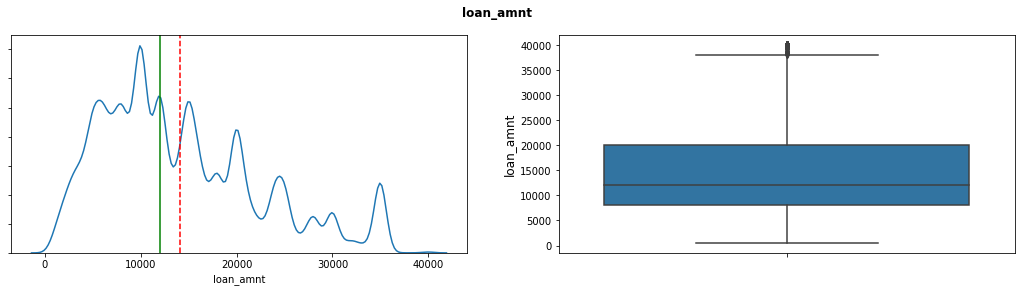

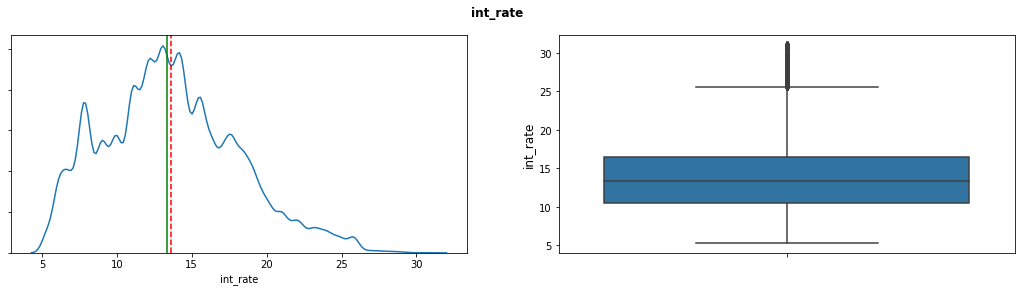

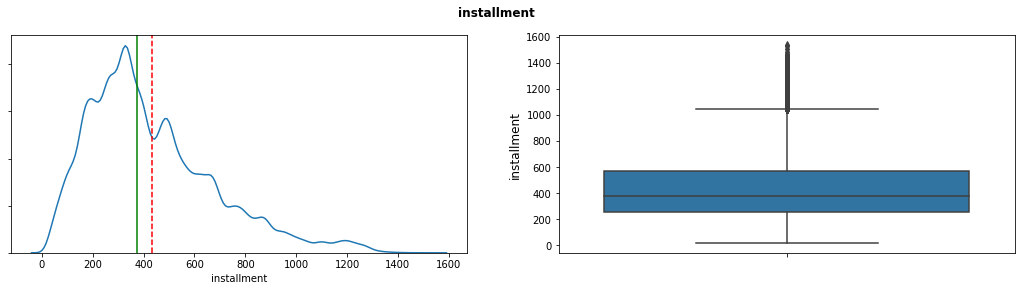

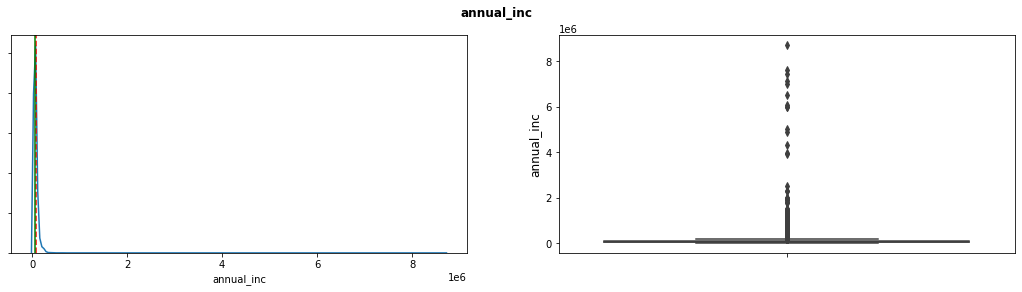

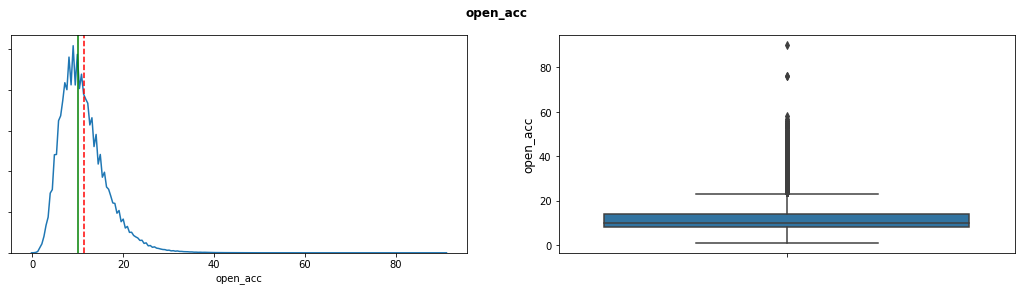

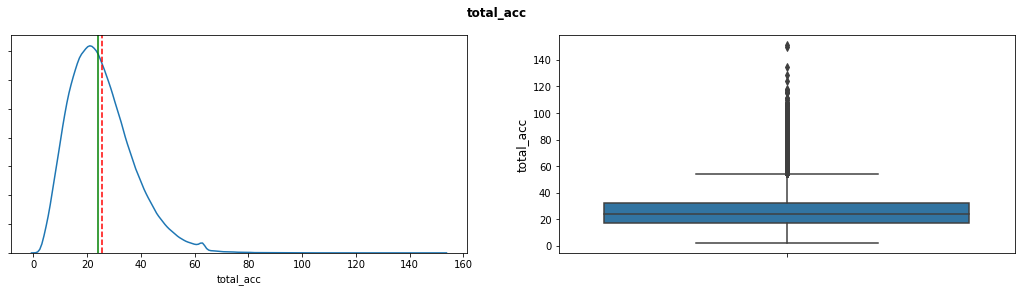

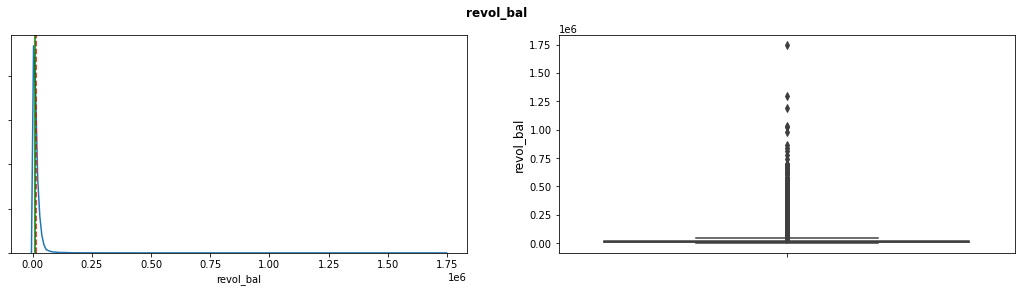

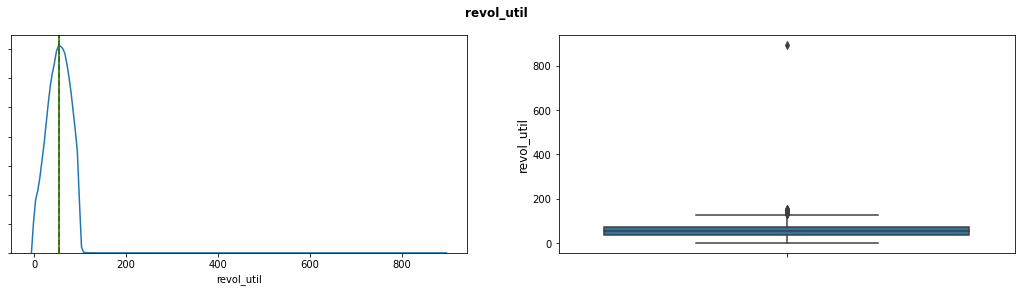

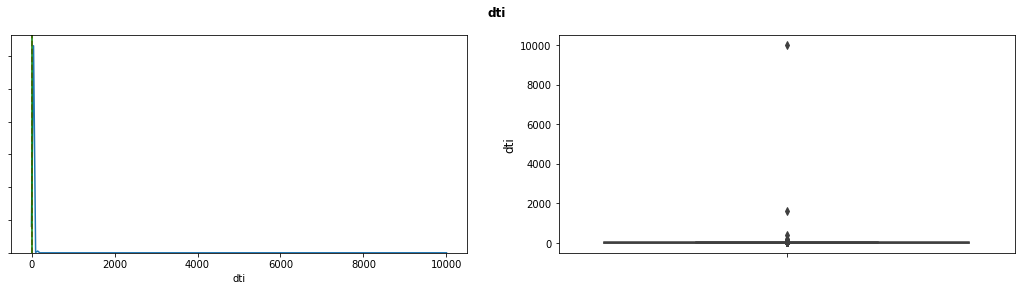

In [ ]:
for col in numerical_cols:
  fig, ax = plt.subplots(1, 2, figsize = (18, 4))
  plt.suptitle(col, fontsize = fontsize, fontweight = fontweight)
  kdeplot(loantap_data, col, None, ax[0])
  boxplot(loantap_data, col, None, ax[1])
  #scatterplotonecol(loantap_data, col, None, ax[2])

In [ ]:
loantap_data_new = loantap_data.copy()
q1 = loantap_data_new[numerical_cols].quantile(0.25)
q3 = loantap_data_new[numerical_cols].quantile(0.75)
iqr = q3 -q1

loantap_data_new = loantap_data_new[~((loantap_data_new[numerical_cols]<q1-1.5*iqr) | (loantap_data_new[numerical_cols]>q3+1.5*iqr)).any(axis = 1)]
loantap_data_new = loantap_data_new.reset_index(drop = True)

perc = ((loantap_data.shape[0] -  loantap_data_new.shape[0])/loantap_data.shape[0])*100
perc


13.854850095769688

### **Inference**

<ul>
<li>From the above plots, it can be interpreted as many outliers and hence it needs to be handled post train - test split
<li>As outliers detection and treatment can be done after train-test split, we won't do with the iqr based median imputation for outliers. We will treat it after split.
<li> If we remove outliers of the data using IQR, then around 13% data is getting removed. Hence we won't remove the outliers, we will treat it after train-test split
</ul>

# **Visual Univariate Analysis - Categorical Variables**

In [ ]:
loantap_data.select_dtypes(['object']).columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address'],
      dtype='object')

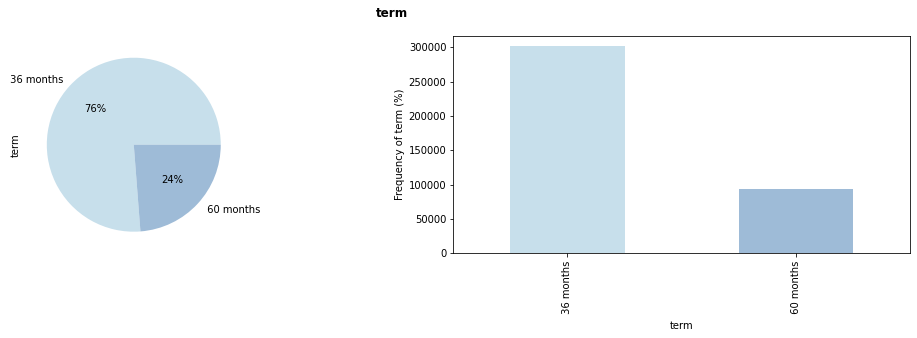

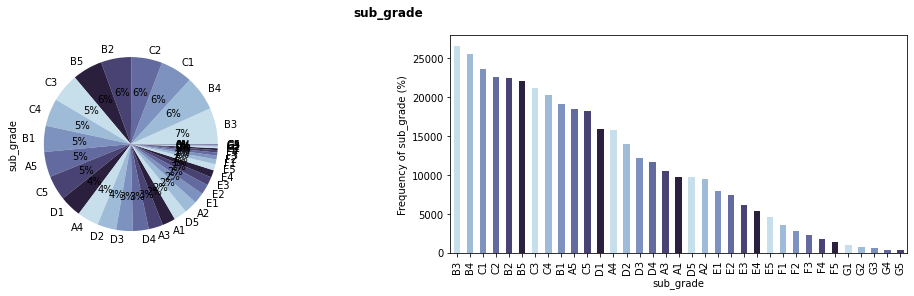

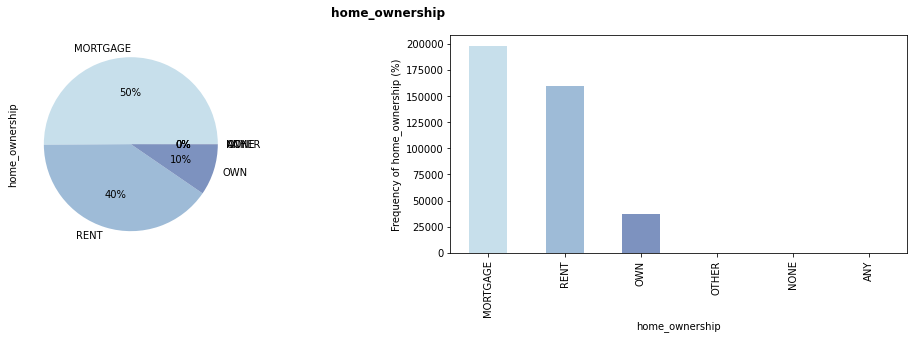

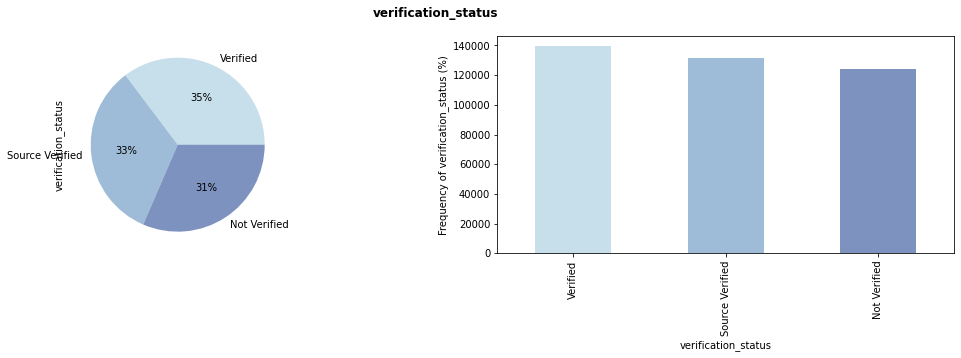

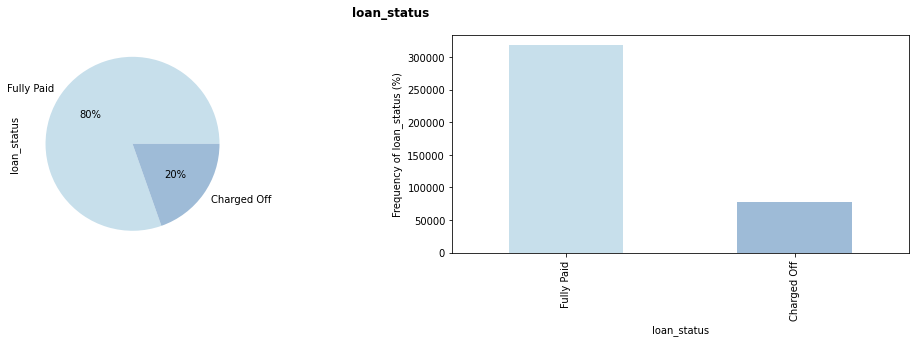

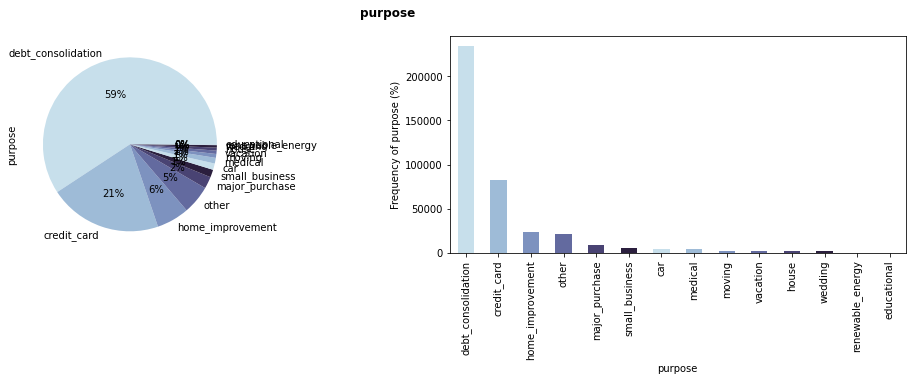

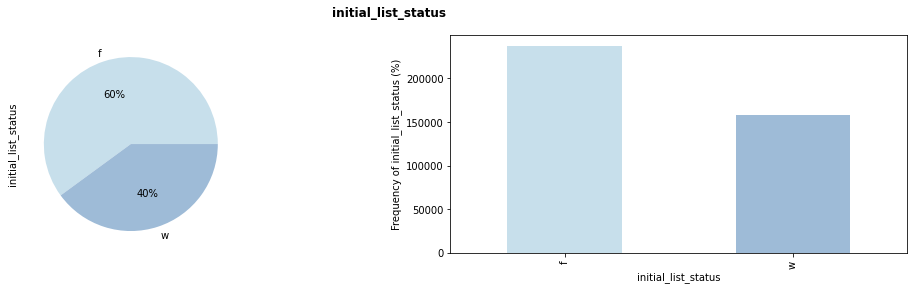

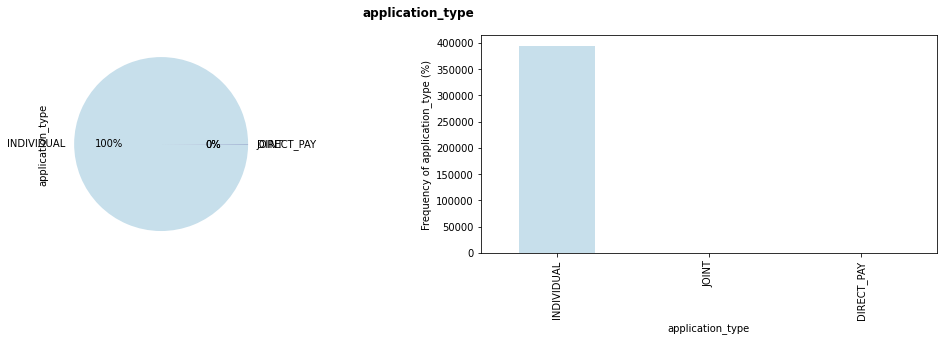

In [ ]:
cat_cols = ['term', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'initial_list_status', 'application_type']
for col in cat_cols:
  fig, ax = plt.subplots(1, 2, figsize = (18, 4))
  plt.suptitle(col, fontsize = fontsize, fontweight = fontweight)
  pieplot(loantap_data,col,ax[0])
  barplot(loantap_data,col,ax[1])

### **Inference**

<ul>
<li>76% of the customers are using 36 months as number of payments on the loan
<li>33% of the customers have 10+ years of experience
<li>50% of the customers have MORTGAGE as home ownership
</li>Initial list status for 60% of the customers are "f"
<li>59% of the customers have debt_consolidation as the purpose of teh loan


# **Visual Bivariate Analysis - Numerical Variables**

## **Correlation**

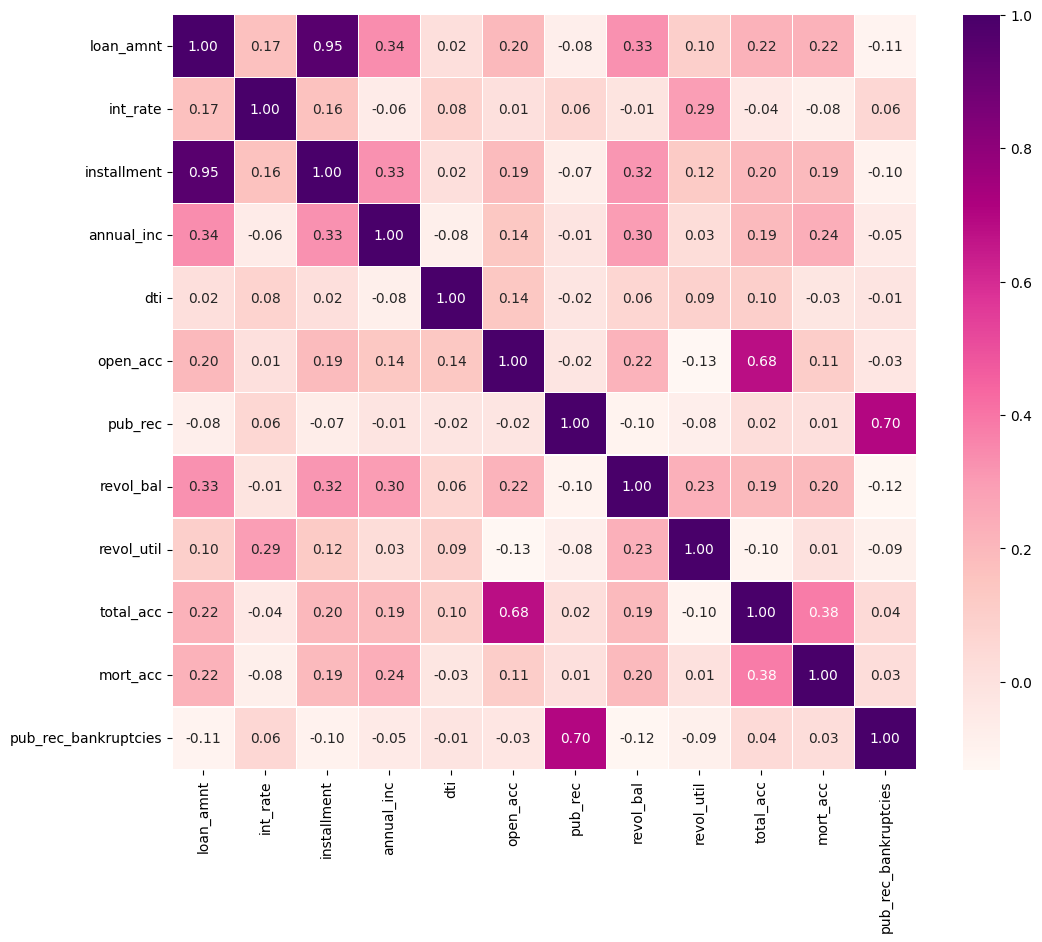

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10),dpi = 100)
sns.heatmap(loantap_data.corr(), annot = True, fmt='.2f', linewidths=.3, ax = ax ,cmap='RdPu')
plt.show()

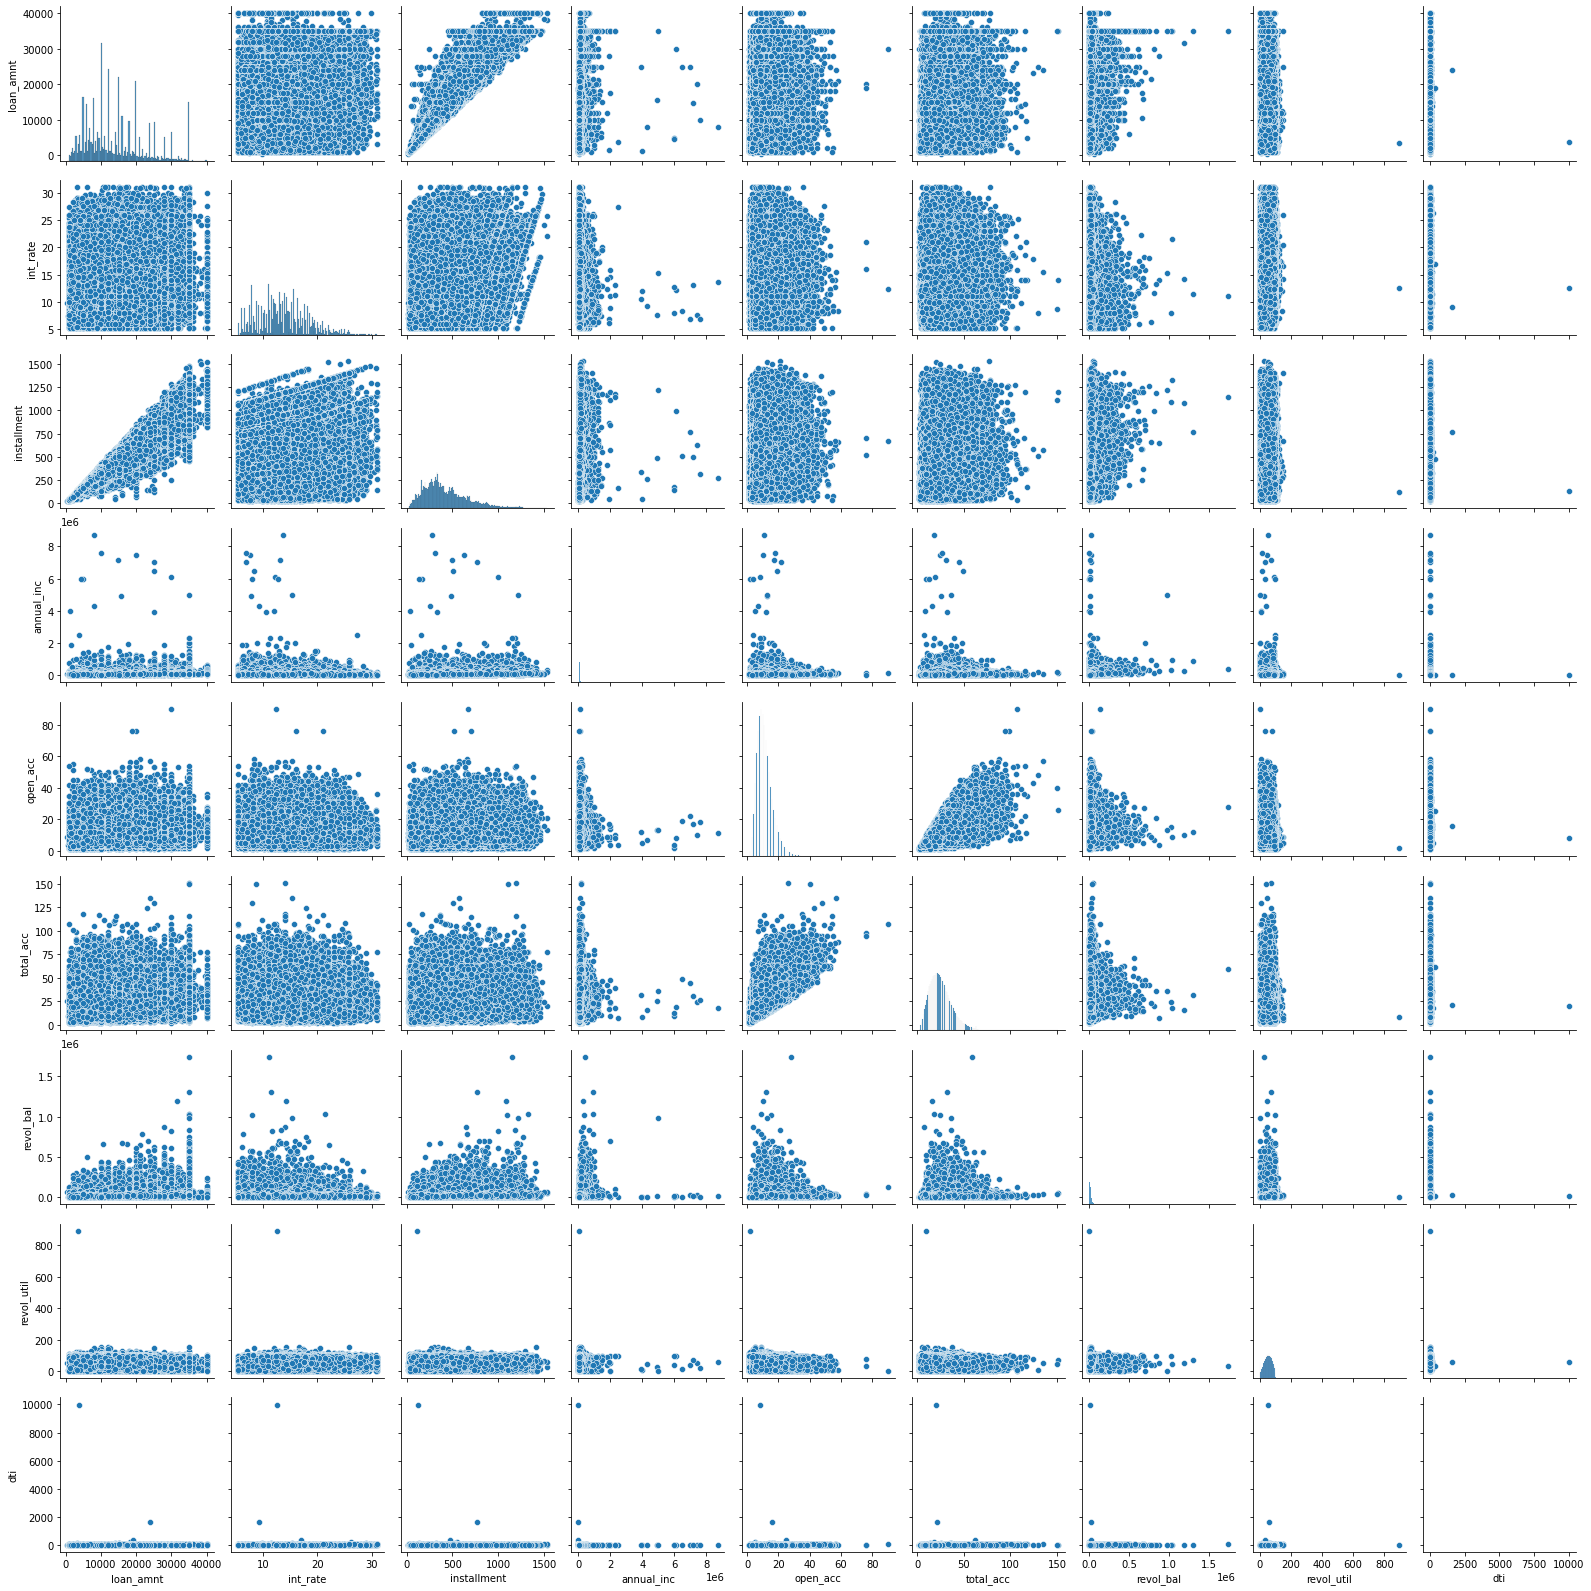

In [ ]:
sns.color_palette("pastel")
sns.pairplot(loantap_data[numerical_cols])
plt.show()

### **Inference**

<ul>
<li>loan_amnt and installment are highly correlated which means , more the number of loan amount, more are the installments.
<li>total_acc and open_acc are highly corelated.
<li>pub_rec_bankruptcies and pub_rec are higly corelated.
</ul>

# **Check how much target variable (Loan_Status) depends on different predictor variables**

## **Relationship between loan_amnt and loan_status**

In [ ]:
loantap_data.groupby(['loan_status'])['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77523.0,15132.578074,8503.989092,1000.0,8575.0,14000.0,20000.0,40000.0
Fully Paid,317696.0,13875.478681,8302.172723,500.0,7500.0,12000.0,19275.0,40000.0


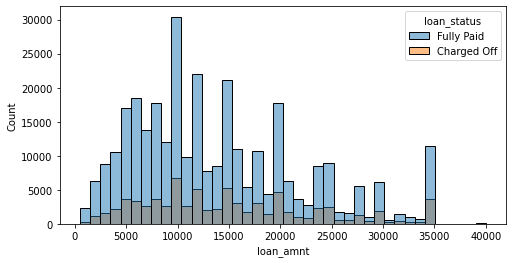

In [ ]:
plt.figure(figsize = (8,4))
sns.histplot(data = loantap_data, x = 'loan_amnt', bins = 40, hue = 'loan_status', color = 'crimson')
plt.show()

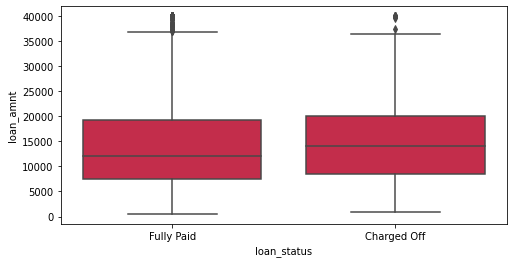

In [ ]:
plt.figure(figsize = (8,4))
sns.boxplot(x='loan_status',y='loan_amnt',data=loantap_data, color = 'crimson')
plt.show()

## **Relationship between loan_amnt, installment and loan_status**

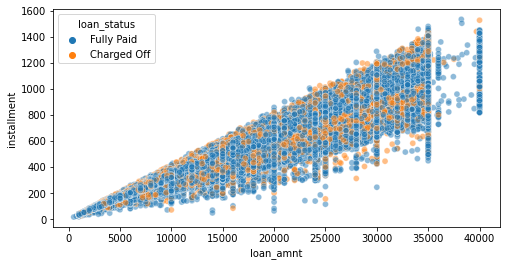

In [ ]:
plt.figure(figsize = (8,4))
sns.scatterplot(data = loantap_data, x = 'loan_amnt', y = 'installment', alpha = 0.5, hue = 'loan_status', color = 'crimson')
plt.show()

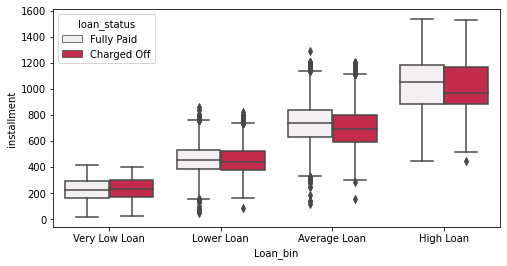

In [ ]:
bins = [0, 10000, 20000, 30000, 40000]
group_name = ['Very Low Loan', 'Lower Loan', 'Average Loan', 'High Loan']

loantap_data['Loan_bin'] = pd.cut(loantap_data['loan_amnt'], bins = bins,labels = group_name)

plt.figure(figsize = (8,4))
sns.boxplot(data = loantap_data, x = 'Loan_bin', y = 'installment',  hue = 'loan_status', color = 'crimson')
plt.show()

In [ ]:
loantap_data = loantap_data.drop('Loan_bin', axis = 1)

### **Inference**

<ul>
<li>When the loan taken is less than 20000, then the installments in form of the monthly payment owed by the borrower if the loan originates, are similar to both types of borrowers who have defaulted and who had fully paaid the loan.

<li>But as loan amount increases, the installments owed by the defaulters decreases as compared to the installments by the honest borrowers who are not defaulting.

## **Relationship between annual_inc and loan_status**

In [ ]:
loantap_data.groupby(['loan_status'])['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77523.0,67526.852852,58310.628403,0.0,42000.00,59000.0,80000.0,8706582.0
Fully Paid,317696.0,75827.575913,62215.381438,600.0,46171.25,65000.0,90000.0,7600000.0


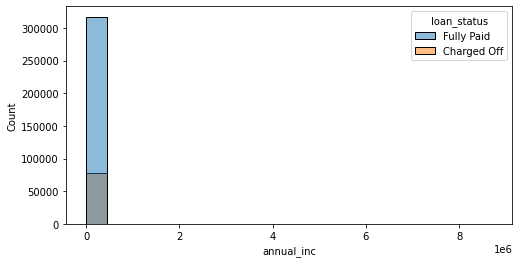

In [ ]:
plt.figure(figsize = (8,4))
sns.histplot(data = loantap_data, x = 'annual_inc', bins = 20, hue = 'loan_status', color = 'crimson')
plt.show()

## **Relationship between annual_inc, installment and loan_status**



In [ ]:
bins = [0, 25000, 50000, 100000, 500000, 1200000, 2500000, 8706582]
group_name = ['BPL', 'Very Low', 'Low', 'Average', 'Better off', 'High', 'Very High']

loantap_data['Income_bin'] = pd.cut(loantap_data['annual_inc'], bins = bins,labels = group_name)
loantap_data['Income_bin']

0          Average
1              Low
2         Very Low
3              Low
4              Low
            ...   
396025    Very Low
396026     Average
396027         Low
396028         Low
396029    Very Low
Name: Income_bin, Length: 395219, dtype: category
Categories (7, object): ['BPL' < 'Very Low' < 'Low' < 'Average' < 'Better off' < 'High' < 'Very High']

In [ ]:
Income_bin = pd.crosstab(loantap_data['Income_bin'], loantap_data['loan_status'])
Income_bin

loan_status,Charged Off,Fully Paid
Income_bin,,
BPL,3841,10742
Very Low,26960,89294
Low,36729,159430
Average,9936,57884
Better off,50,308
High,4,26
Very High,2,12


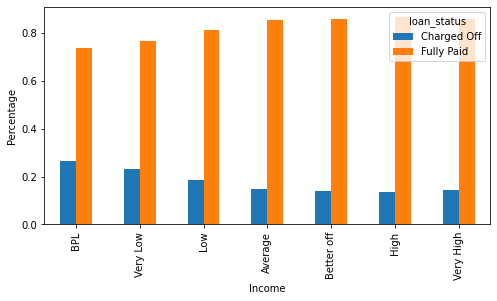

In [ ]:
Income_bin.div(Income_bin.sum(axis = 1), axis = 0).plot(kind = 'bar', figsize = (8,4))
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.show()

In [ ]:
loantap_data = loantap_data.drop('Income_bin', axis = 1)

### **Inference**

<ul>
<li>There's a high possibility of borrower defaulting (charged-off) when the income is below poverty line, very low and low category. Whereas, there are few cases where customers with high and very high income also have defaulted the loan.

## **Relationship between int_rate and loan_status**

<Figure size 576x288 with 0 Axes>

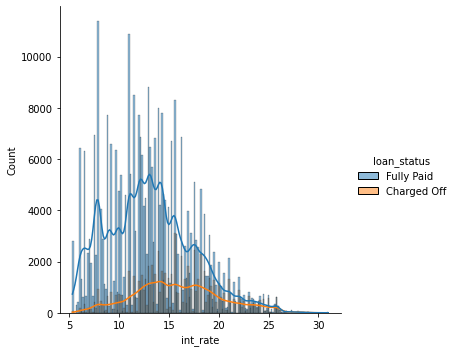

In [ ]:
plt.figure(figsize = (8,4))
sns.displot(data = loantap_data, x = 'int_rate' , hue = 'loan_status', kde = True)
plt.show()

## **Relationship between Grades and loan_status**

In [ ]:
sorted(loantap_data['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [ ]:
loantap_data['sub_grade'].unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

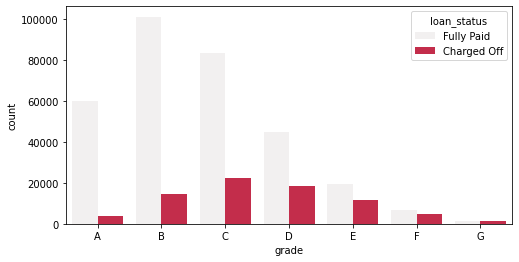

In [ ]:
order = sorted(loantap_data['grade'].unique())
plt.figure(figsize = (8,4))
sns.countplot(x='grade',data=loantap_data,hue='loan_status', order = order, color = 'crimson')
plt.show()

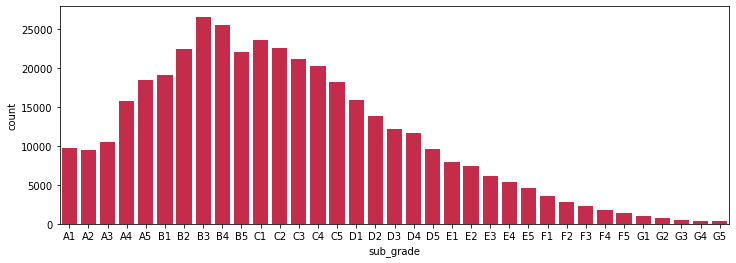

In [ ]:
plt.figure(figsize=(12,4))
order = sorted(loantap_data['sub_grade'].unique())
sns.countplot(x='sub_grade',data=loantap_data,order = order,color = 'crimson')
plt.show()

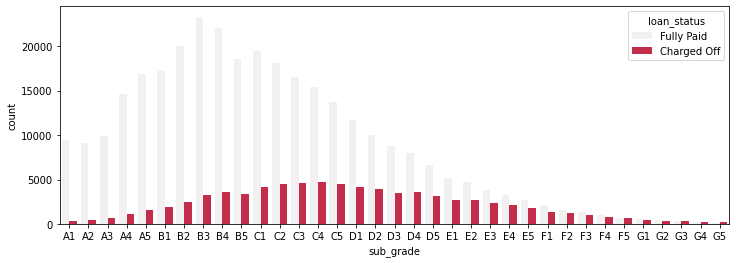

In [ ]:
order = sorted(loantap_data['sub_grade'].unique())
plt.figure(figsize = (12,4))
sns.countplot(x='sub_grade',data=loantap_data,hue='loan_status', order = order, color = 'crimson')
plt.show()

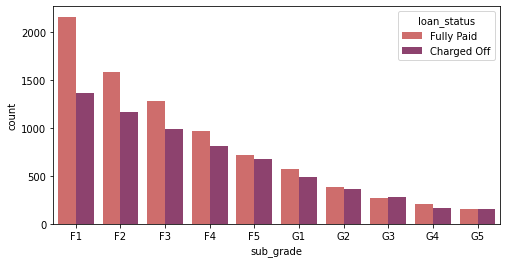

In [ ]:
filtered_f_g = loantap_data[(loantap_data.grade == 'F') | (loantap_data.grade == 'G')]
order = sorted(filtered_f_g['sub_grade'].unique())
plt.figure(figsize = (8,4))
sns.countplot(x='sub_grade', data=filtered_f_g, hue='loan_status', order = order, palette='flare')
plt.show()

### **Inference**

<ul>
<li>It is obvious that F and G grades have a high default rate.
<li>If your sub grade is G5: the probability that you will default is almost 50%

## **Dropping non informative columns**

In [ ]:
loantap_data = loantap_data.drop('emp_title', axis = 1)

In [ ]:
loantap_data = loantap_data.drop('emp_length', axis = 1)

In [ ]:
loantap_data = loantap_data.drop('title', axis = 1)

In [ ]:
loantap_data = loantap_data.drop('grade', axis = 1)

In [ ]:
loantap_data = loantap_data.drop('issue_d',axis=1)

### **Inference**

<ul>
<li>emp_title will not be informative because half people (173k) have unique titles, so we have dropped it
<li>Dropping title as it's showing similar details as purpose
<li>Dropping the grade feature as grade is part of sub_grade
<li>We are not sure whether the loan is issued or not, so the feature issue_dt will not be informative

# **Feature Engineering**

<ul>
<li>Creation of Flags- If value greater than 1.0 then 1 else 0. This can be done on:

1. Pub_rec
2. Mort_acc
3. Pub_rec_bankruptcies

<li> Create zip_code from address
<li> Extract year from earliest_cr_line
<li> Loan Amount Binning
<li> annual_inc Binning

## **Pub_rec**

In [ ]:
loantap_data['pub_rec'].value_counts()

0.0     337489
1.0      49713
2.0       5474
3.0       1521
4.0        527
5.0        237
6.0        122
7.0         56
8.0         34
9.0         12
10.0        11
11.0         8
13.0         4
12.0         4
19.0         2
40.0         1
17.0         1
86.0         1
24.0         1
15.0         1
Name: pub_rec, dtype: int64

In [ ]:
loantap_data['pub_rec'] = loantap_data['pub_rec'].apply(lambda x: 1 if x > 0.0 else 0)

In [ ]:
loantap_data['pub_rec'].value_counts()

0    337489
1     57730
Name: pub_rec, dtype: int64

In [ ]:
 loantap_data['pub_rec'] =  loantap_data['pub_rec'].astype('int64')

## **Mort_acc**

In [ ]:
loantap_data['mort_acc'].value_counts()

0.0     139708
1.0      60384
2.0      49907
3.0      38022
4.0      27865
5.0      18182
6.0      11059
7.0       6050
8.0       3120
9.0       1653
10.0       863
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
32.0         2
31.0         2
23.0         2
26.0         2
28.0         1
30.0         1
34.0         1
Name: mort_acc, dtype: int64

In [ ]:
#loantap_data['mort_acc'] = loantap_data['mort_acc'].apply(lambda x: 1 if x > 0.0 else 0)

In [ ]:
#loantap_data['mort_acc'].value_counts()

### **Inference**

<ul>
<li>mort_acc has missing values so feature Engineering will be done post train-test split
</ul>

## **Pub_rec_bankruptcies**

In [ ]:
loantap_data['pub_rec_bankruptcies'].value_counts()

0.0    350108
1.0     42786
2.0      1847
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: pub_rec_bankruptcies, dtype: int64

In [ ]:
loantap_data['pub_rec_bankruptcies'] = loantap_data['pub_rec_bankruptcies'].apply(lambda x: 1 if x > 0.0 else 0)

In [ ]:
loantap_data['pub_rec_bankruptcies'].value_counts()

0    350108
1     45111
Name: pub_rec_bankruptcies, dtype: int64

In [ ]:
 loantap_data['pub_rec_bankruptcies'] =  loantap_data['pub_rec_bankruptcies'].astype('int64')

## **address**

In [ ]:
loantap_data['address'][0]

'0174 Michelle Gateway\r\nMendozaberg, OK 22690'

In [ ]:
loantap_data['zip_code'] = loantap_data['address'].apply(lambda address:address[-5:])

In [ ]:
loantap_data['zip_code'].value_counts()

70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: zip_code, dtype: int64

## **earliest_cr_line**

In [ ]:
loantap_data['earliest_cr_line'].value_counts()

Oct-2000    3013
Aug-2000    2930
Oct-2001    2890
Aug-2001    2879
Nov-2000    2729
            ... 
Jul-1955       1
Oct-1950       1
May-1958       1
Nov-1955       1
Aug-1959       1
Name: earliest_cr_line, Length: 684, dtype: int64

In [ ]:
loantap_data['earliest_cr_year'] = loantap_data['earliest_cr_line'].apply(lambda date:int(date[-4:]))
loantap_data = loantap_data.drop('earliest_cr_line',axis=1)

In [ ]:
loantap_data['earliest_cr_year'].value_counts()

2000    29302
2001    29031
1999    26444
2002    25849
2003    23623
        ...  
1951        3
1950        3
1953        2
1944        1
1948        1
Name: earliest_cr_year, Length: 65, dtype: int64

## **loan_amnt**

In [ ]:
bins = [0, 10000, 20000, 30000, 40000]
group_name = ['Very Low Loan', 'Lower Loan', 'Average Loan', 'High Loan']

loantap_data['Loan_bin'] = pd.cut(loantap_data['loan_amnt'], bins = bins,labels = group_name)
loantap_data['Loan_bin']

0         Very Low Loan
1         Very Low Loan
2            Lower Loan
3         Very Low Loan
4          Average Loan
              ...      
396025    Very Low Loan
396026     Average Loan
396027    Very Low Loan
396028     Average Loan
396029    Very Low Loan
Name: Loan_bin, Length: 395219, dtype: category
Categories (4, object): ['Very Low Loan' < 'Lower Loan' < 'Average Loan' < 'High Loan']

## **annual_inc**

In [ ]:
bins = [0, 25000, 50000, 100000, 500000, 1200000, 2500000, 8706582]
group_name = ['BPL', 'Very Low', 'Low', 'Average', 'Better off', 'High', 'Very High']

loantap_data['Income_bin'] = pd.cut(loantap_data['annual_inc'], bins = bins,labels = group_name)
loantap_data['Income_bin']

0          Average
1              Low
2         Very Low
3              Low
4              Low
            ...   
396025    Very Low
396026     Average
396027         Low
396028         Low
396029    Very Low
Name: Income_bin, Length: 395219, dtype: category
Categories (7, object): ['BPL' < 'Very Low' < 'Low' < 'Average' < 'Better off' < 'High' < 'Very High']

# **Handling categorical values**

## **Encoding - loan_status**

In [ ]:
categorical_cols = ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'initial_list_status', 'application_type','purpose']
encode_dict = {'Charged Off':1, 'Fully Paid':0}
loantap_data['loan_status'] = loantap_data['loan_status'].map(encode_dict)

val_counts  = loantap_data['loan_status'].value_counts(normalize = True) * 100
pd.DataFrame(val_counts.round())

,loan_status
0,80.0
1,20.0


## **Encoding - term**

In [ ]:
encode_dict = {' 36 months':0, ' 60 months':1}
loantap_data['term'] = loantap_data['term'].map(encode_dict)

val_counts  = loantap_data['term'].value_counts(normalize = True) * 100
pd.DataFrame(val_counts.round())

,term
0,76.0
1,24.0


In [ ]:
loantap_data.select_dtypes(['object']).columns

Index(['sub_grade', 'home_ownership', 'verification_status', 'purpose',
       'initial_list_status', 'application_type', 'address', 'zip_code'],
      dtype='object')

## **Encoding - sub_grade**

In [ ]:
subgrade_dummies = pd.get_dummies(loantap_data['sub_grade'],drop_first=True)
loantap_data = pd.concat([loantap_data.drop('sub_grade',axis=1),subgrade_dummies],axis=1)

In [ ]:
loantap_data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'address', 'zip_code', 'earliest_cr_year',
       'Loan_bin', 'Income_bin', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3',
       'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5',
       'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2',
       'G3', 'G4', 'G5'],
      dtype='object')

## **Encoding - home_ownership**

In [ ]:
loantap_data['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

In [ ]:
loantap_data['home_ownership']=loantap_data['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')
home_ownership_dummies = pd.get_dummies(loantap_data['home_ownership'],drop_first=True)
loantap_data = loantap_data.drop('home_ownership',axis=1)
loantap_data = pd.concat([loantap_data,home_ownership_dummies],axis=1)

## **Encoding - verification_status, application_type,initial_list_status,purpose**

In [ ]:
dummies = pd.get_dummies(loantap_data[['verification_status', 'application_type','initial_list_status','purpose' ]],drop_first=True)
loantap_data = loantap_data.drop(['verification_status', 'application_type','initial_list_status','purpose'],axis=1)
loantap_data = pd.concat([loantap_data,dummies],axis=1)

## **Encoding - zip_code**

In [ ]:
zip_code_dummies = pd.get_dummies(loantap_data['zip_code'],drop_first=True)
loantap_data = loantap_data.drop(['zip_code','address'],axis=1)
loantap_data = pd.concat([loantap_data,zip_code_dummies],axis=1)

## **Encoding - Loan_bin**

In [ ]:
loantap_data['Loan_bin'].value_counts()

Very Low Loan    163818
Lower Loan       150715
Average Loan      60192
High Loan         20494
Name: Loan_bin, dtype: int64

In [ ]:
dummies = pd.get_dummies(loantap_data['Loan_bin'],drop_first=True)
loantap_data = loantap_data.drop('Loan_bin',axis=1)
loantap_data = pd.concat([loantap_data,dummies],axis=1)

## **Encoding - Income_bin**

In [ ]:
loantap_data['Income_bin'].value_counts()

Low           196159
Very Low      116254
Average        67820
BPL            14583
Better off       358
High              30
Very High         14
Name: Income_bin, dtype: int64

In [ ]:
loantap_data['Income_bin']=loantap_data['Income_bin'].replace([ 'High', 'Very High'], 'OTHER')

In [ ]:
dummies = pd.get_dummies(loantap_data['Income_bin'],drop_first=True)
loantap_data = loantap_data.drop('Income_bin',axis=1)
loantap_data = pd.concat([loantap_data,dummies],axis=1)

In [ ]:
loantap_data.select_dtypes(['object']).columns

Index([], dtype='object')

In [ ]:
loantap_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395219 entries, 0 to 396029
Data columns (total 87 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            395219 non-null  float64
 1   term                                 395219 non-null  int64  
 2   int_rate                             395219 non-null  float64
 3   installment                          395219 non-null  float64
 4   annual_inc                           395219 non-null  float64
 5   loan_status                          395219 non-null  int64  
 6   dti                                  395219 non-null  float64
 7   open_acc                             395219 non-null  float64
 8   pub_rec                              395219 non-null  int64  
 9   revol_bal                            395219 non-null  float64
 10  revol_util                           395219 non-null  float64
 11  total_acc    

In [ ]:
loantap_data.shape

(395219, 87)

# **Logistics Regression**

In [ ]:
X= loantap_data.drop(["loan_status"],axis =1)
y= loantap_data["loan_status"]

In [ ]:
X.shape,y.shape

((395219, 86), (395219,))

## **Splitting the data into train, validation and test - Cross Validation**

In [ ]:
X_tr_cv, X_test, y_tr_cv, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr_cv, y_tr_cv, test_size=0.2)
X_train.shape,y_train.shape, X_val.shape,y_val.shape, X_test.shape, y_test.shape

((252940, 86), (252940,), (63235, 86), (63235,), (79044, 86), (79044,))

## **Missing value imputation on Train Data**

In [ ]:
missing_val = missingValue(X_train)
missing_val[missing_val['Total Missing'] > 0]

Total records =  252940


,Total Missing,In Percent
mort_acc,23842,9.43


At this point , we will do the missing value handling using median imputation for missing value for 'mort_acc'


In [ ]:
X_train['mort_acc'].value_counts()

0.0     89389
1.0     38592
2.0     32092
3.0     24269
4.0     17811
5.0     11626
6.0      7108
7.0      3862
8.0      1992
9.0      1041
10.0      541
11.0      311
12.0      166
13.0       88
14.0       76
15.0       37
16.0       22
17.0       19
19.0       13
18.0       11
20.0       10
24.0        6
22.0        3
25.0        3
21.0        2
32.0        2
27.0        2
23.0        2
30.0        1
31.0        1
Name: mort_acc, dtype: int64

In [ ]:
X_train['mort_acc'].median()

1.0

In [ ]:
X_train['mort_acc'] = X_train['mort_acc'].fillna(X_train['mort_acc'].median())

In [ ]:
missing_val = missingValue(X_train)
missing_val[missing_val['Total Missing'] > 0]

Total records =  252940


,Total Missing,In Percent


In [ ]:
X_train['mort_acc'] = X_train['mort_acc'].apply(lambda x: 1 if x > 0.0 else 0)

## **Outlier treatment on Train Data**

In [ ]:
X_train_v1 = X_train.copy()
q1 = X_train_v1[numerical_cols].quantile(0.25)
q3 = X_train_v1[numerical_cols].quantile(0.75)
iqr = q3 -q1

X_train_v1 = X_train_v1[~((X_train_v1[numerical_cols]<q1-1.5*iqr) | (X_train_v1[numerical_cols]>q3+1.5*iqr)).any(axis = 1)]
X_train_v1 = X_train_v1.reset_index(drop = True)

In [ ]:
X_train.shape,X_train_v1.shape

((252940, 86), (217584, 86))

In [ ]:
X_train.shape[0]-X_train_v1.shape[0]

35356

In [ ]:
for i in numerical_cols:
    X_train[i] = np.where(X_train[i] > X_train[i].quantile(0.75) + (X_train[i].quantile(0.75) - X_train[i].quantile(0.25))*1.5,X_train[i].quantile(0.5),X_train[i])
    X_train[i] = np.where(X_train[i] < X_train[i].quantile(0.25) - (X_train[i].quantile(0.75) - X_train[i].quantile(0.25))*1.5, X_train[i].quantile(0.5),X_train[i])

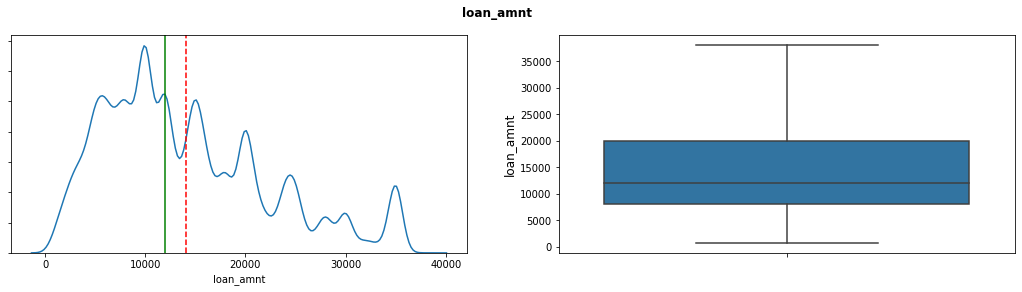

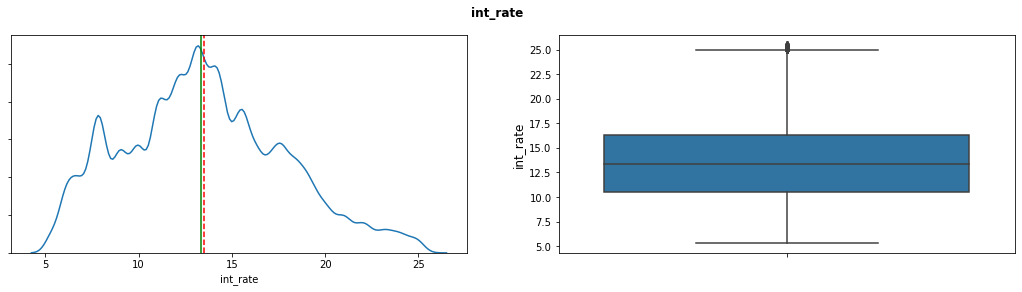

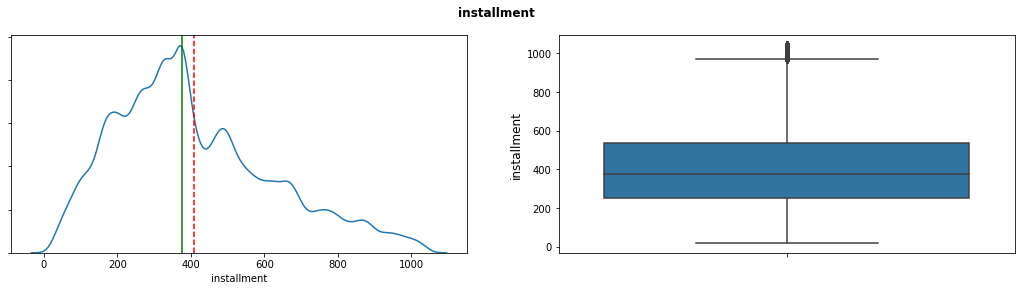

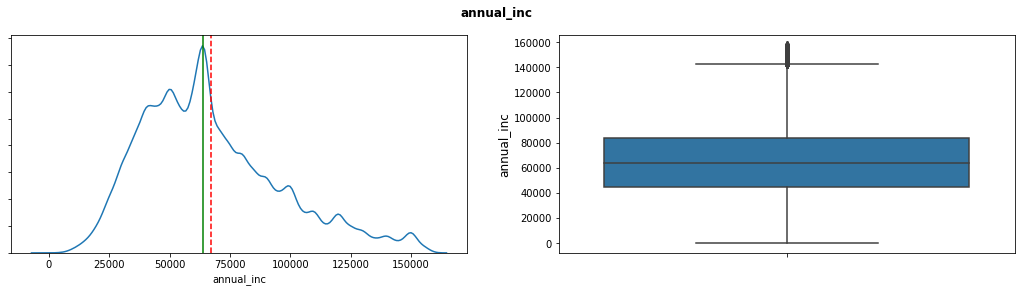

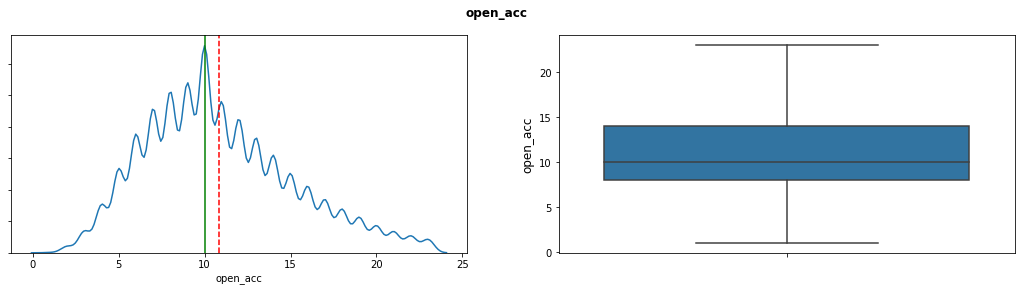

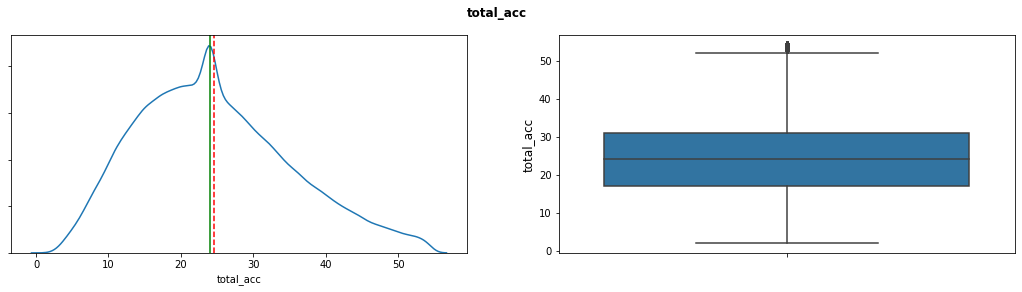

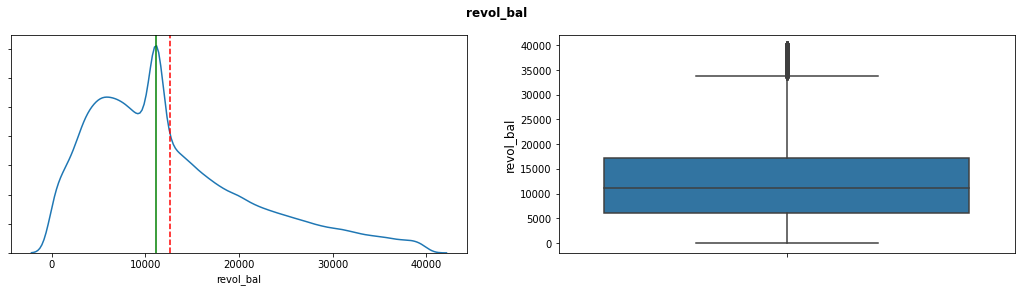

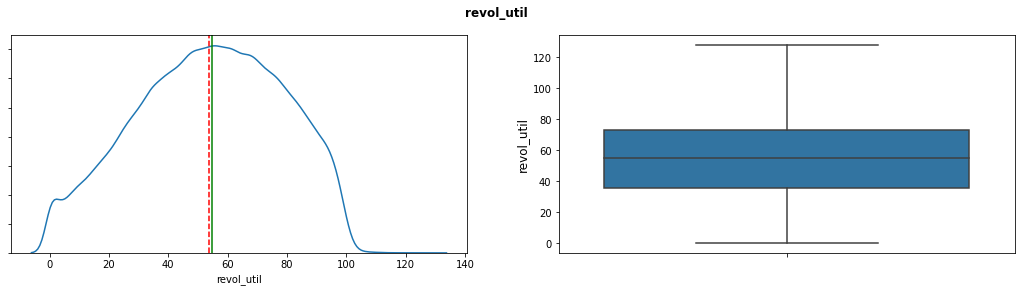

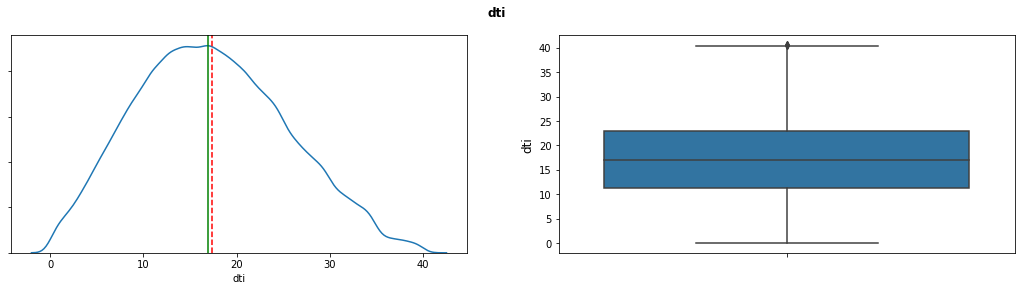

In [ ]:
for col in numerical_cols:
  fig, ax = plt.subplots(1, 2, figsize = (18, 4))
  plt.suptitle(col, fontsize = fontsize, fontweight = fontweight)
  kdeplot(X_train, col, None, ax[0])
  boxplot(X_train, col, None, ax[1])

### **Inference**

<ul>
<li>As we can see from the above plots, the train data is free from outliers from all the important and required numerical features
</ul>

## **Missing value imputation on Validation Data**

In [ ]:
missing_val = missingValue(X_val)
missing_val[missing_val['Total Missing'] > 0]

Total records =  63235


,Total Missing,In Percent
mort_acc,5939,9.39


At this point , we will do the missing value handling using median imputation for missing value for 'mort_acc'


In [ ]:
X_val['mort_acc'].value_counts()

0.0     22337
1.0      9703
2.0      7874
3.0      6171
4.0      4482
5.0      2929
6.0      1705
7.0       960
8.0       523
9.0       277
10.0      140
11.0       74
12.0       45
13.0       24
14.0       17
15.0       11
16.0       10
22.0        4
24.0        2
18.0        2
19.0        2
28.0        1
25.0        1
17.0        1
20.0        1
Name: mort_acc, dtype: int64

In [ ]:
X_val['mort_acc'].median()

1.0

In [ ]:
X_val['mort_acc'] = X_val['mort_acc'].fillna(X_val['mort_acc'].median())

In [ ]:
missing_val = missingValue(X_val)
missing_val[missing_val['Total Missing'] > 0]

Total records =  63235


,Total Missing,In Percent


In [ ]:
X_val['mort_acc'] = X_val['mort_acc'].apply(lambda x: 1 if x > 0.0 else 0)

## **Outlier treatment on Validation Data**

In [ ]:
X_val_v1 = X_val.copy()
q1 = X_val_v1[numerical_cols].quantile(0.25)
q3 = X_val_v1[numerical_cols].quantile(0.75)
iqr = q3 -q1

X_val_v1 = X_val_v1[~((X_val_v1[numerical_cols]<q1-1.5*iqr) | (X_val_v1[numerical_cols]>q3+1.5*iqr)).any(axis = 1)]
X_val_v1 = X_val_v1.reset_index(drop = True)

In [ ]:
X_val.shape,X_val_v1.shape

((63235, 86), (54589, 86))

In [ ]:
X_val.shape[0]-X_val_v1.shape[0]

8646

In [ ]:
for i in numerical_cols:
    X_val[i] = np.where(X_val[i] > X_val[i].quantile(0.75) + (X_val[i].quantile(0.75) - X_val[i].quantile(0.25))*1.5,X_val[i].quantile(0.5),X_val[i])
    X_val[i] = np.where(X_val[i] < X_val[i].quantile(0.25) - (X_val[i].quantile(0.75) - X_val[i].quantile(0.25))*1.5, X_val[i].quantile(0.5),X_val[i])

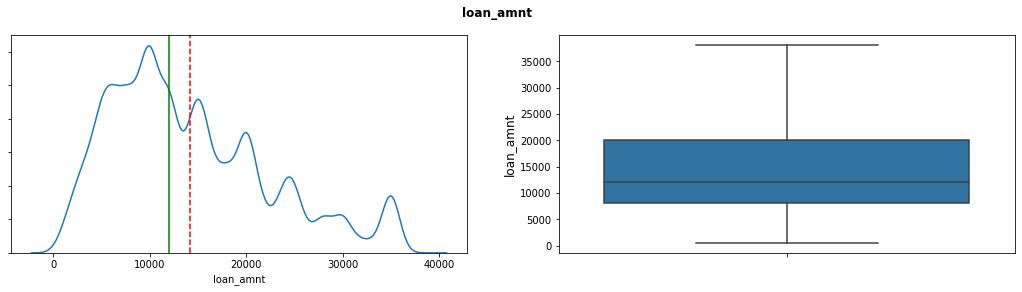

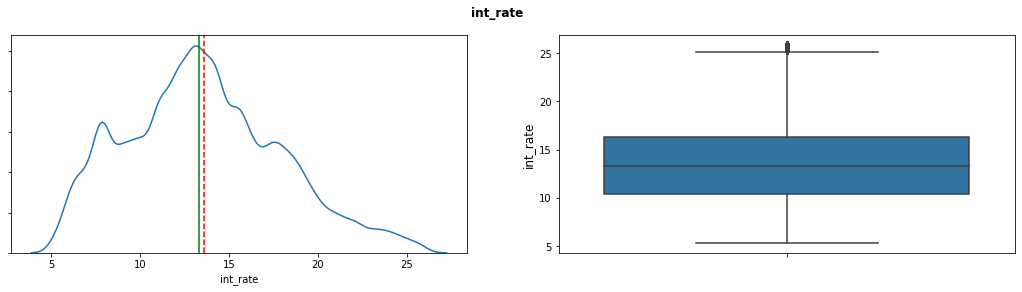

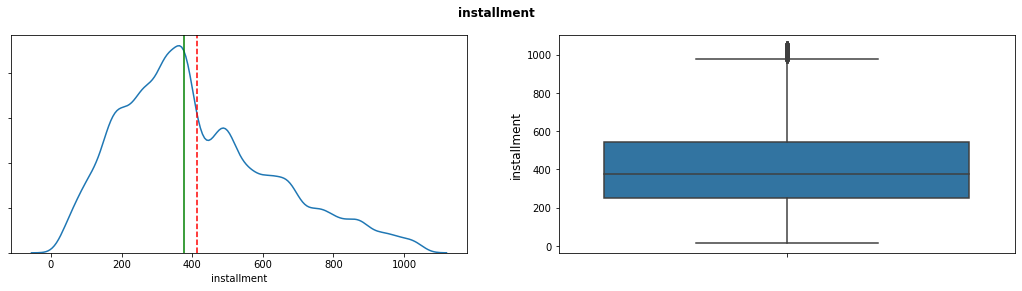

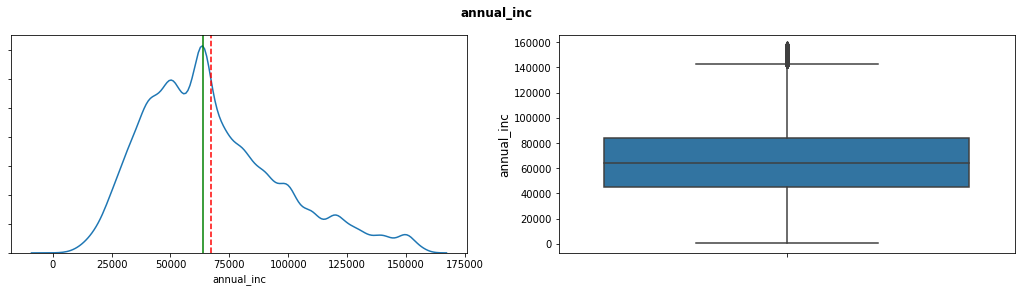

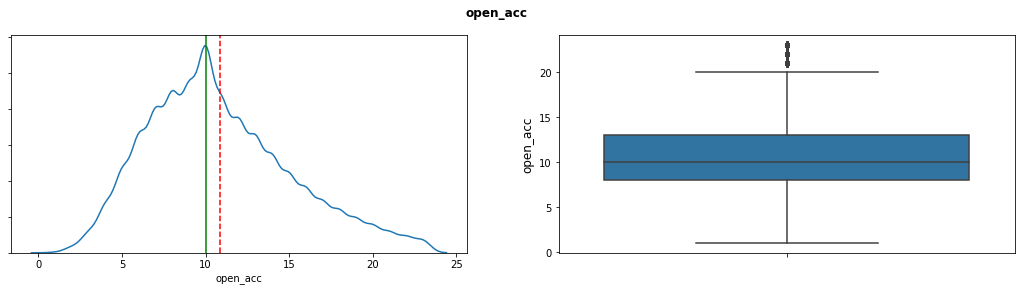

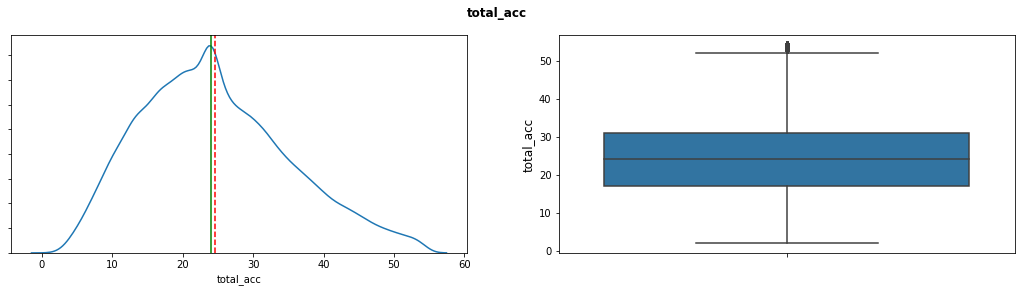

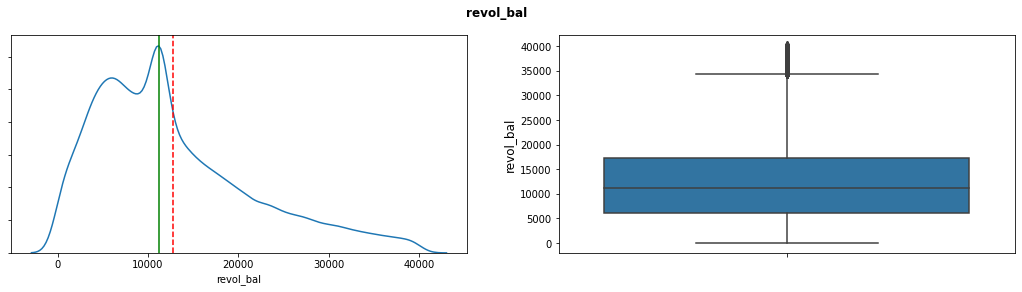

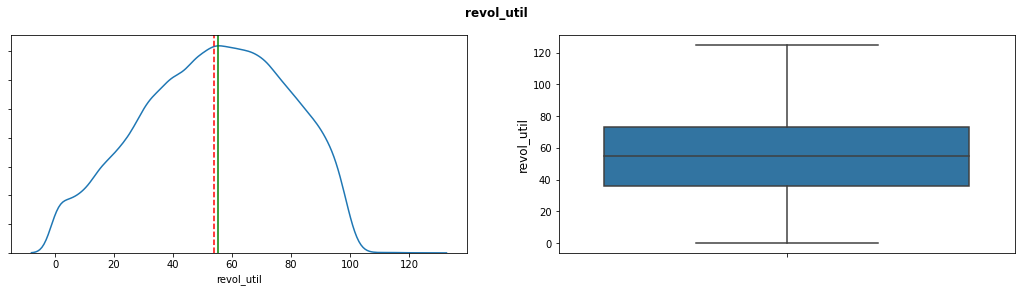

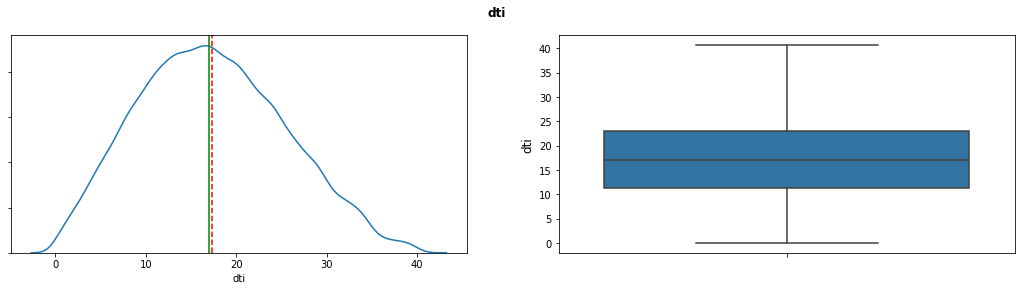

In [ ]:
for col in numerical_cols:
  fig, ax = plt.subplots(1, 2, figsize = (18, 4))
  plt.suptitle(col, fontsize = fontsize, fontweight = fontweight)
  kdeplot(X_val, col, None, ax[0])
  boxplot(X_val, col, None, ax[1])

### **Inference**

<ul>
<li>As we can see from the above plots, the validation data is free from outliers from all the important and required numerical features
</ul>

## **Missing value imputation on Test Data**

In [ ]:
missing_val = missingValue(X_test)
missing_val[missing_val['Total Missing'] > 0]

Total records =  79044


,Total Missing,In Percent
mort_acc,7424,9.39


At this point , we will do the missing value handling using median imputation for missing value for 'mort_acc'


In [ ]:
X_test['mort_acc'].value_counts()

0.0     27982
1.0     12089
2.0      9941
3.0      7582
4.0      5572
5.0      3627
6.0      2246
7.0      1228
8.0       605
9.0       335
10.0      182
11.0       94
12.0       53
13.0       34
14.0       14
15.0       13
18.0        5
16.0        5
20.0        2
21.0        2
17.0        2
26.0        2
24.0        2
27.0        1
31.0        1
34.0        1
Name: mort_acc, dtype: int64

In [ ]:
X_test['mort_acc'].median()

1.0

In [ ]:
X_test['mort_acc'] = X_test['mort_acc'].fillna(X_test['mort_acc'].median())

In [ ]:
missing_val = missingValue(X_test)
missing_val[missing_val['Total Missing'] > 0]

Total records =  79044


,Total Missing,In Percent


In [ ]:
X_test['mort_acc'] = X_test['mort_acc'].apply(lambda x: 1 if x > 0.0 else 0)

## **Outlier treatment on Test Data**

In [ ]:
X_test_v1 = X_test.copy()
q1 = X_test_v1[numerical_cols].quantile(0.25)
q3 = X_test_v1[numerical_cols].quantile(0.75)
iqr = q3 -q1

X_test_v1 = X_test_v1[~((X_test_v1[numerical_cols]<q1-1.5*iqr) | (X_test_v1[numerical_cols]>q3+1.5*iqr)).any(axis = 1)]
X_test_v1 = X_test_v1.reset_index(drop = True)

In [ ]:
X_test.shape,X_test_v1.shape

((79044, 86), (68068, 86))

In [ ]:
X_test.shape[0]-X_test_v1.shape[0]

10976

In [ ]:
for i in numerical_cols:
    X_test[i] = np.where(X_test[i] > X_test[i].quantile(0.75) + (X_test[i].quantile(0.75) - X_test[i].quantile(0.25))*1.5,X_test[i].quantile(0.5),X_test[i])
    X_test[i] = np.where(X_test[i] < X_test[i].quantile(0.25) - (X_test[i].quantile(0.75) - X_test[i].quantile(0.25))*1.5, X_test[i].quantile(0.5),X_test[i])

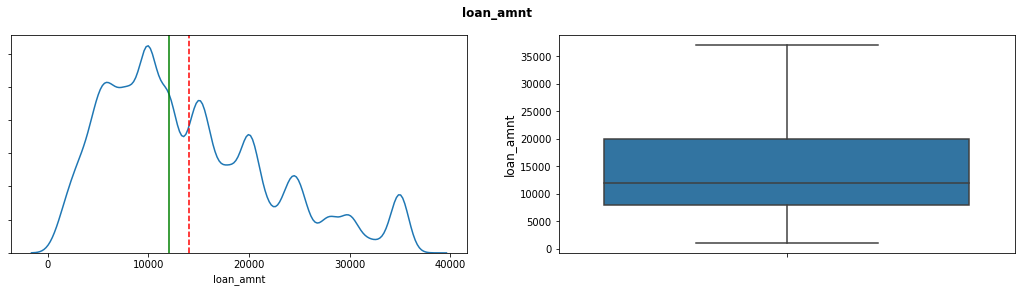

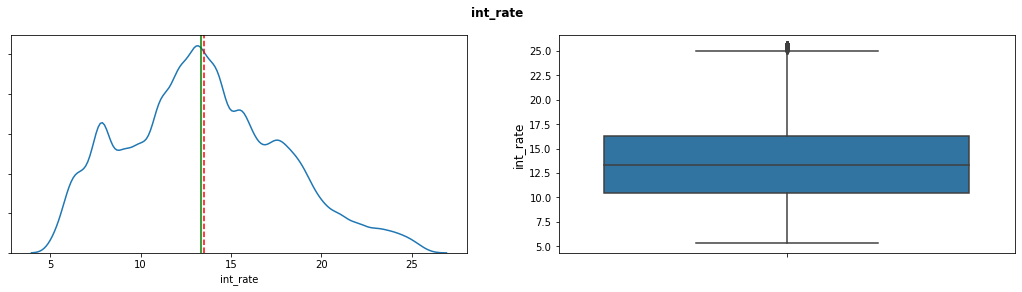

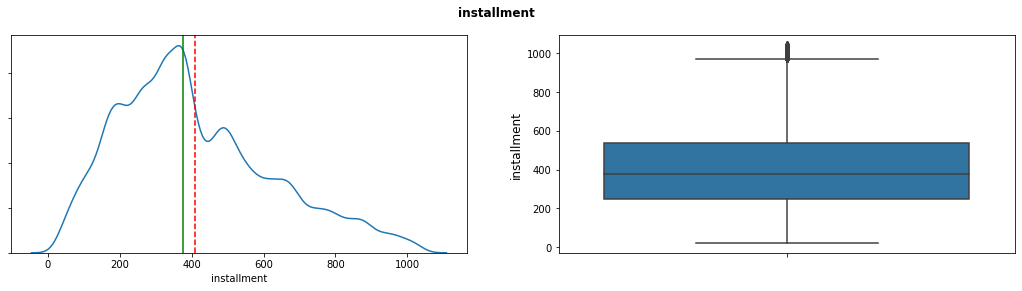

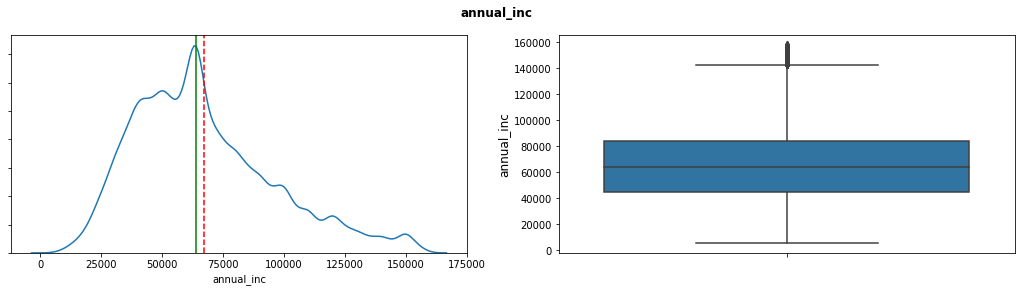

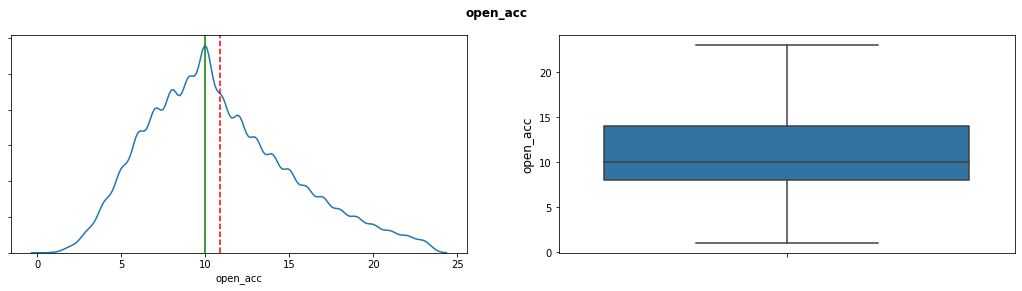

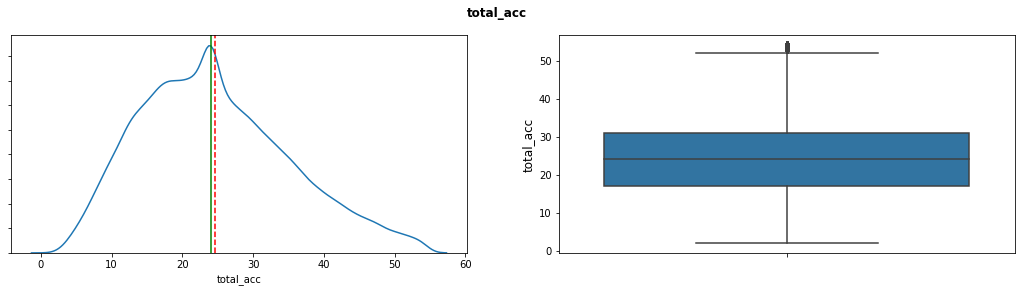

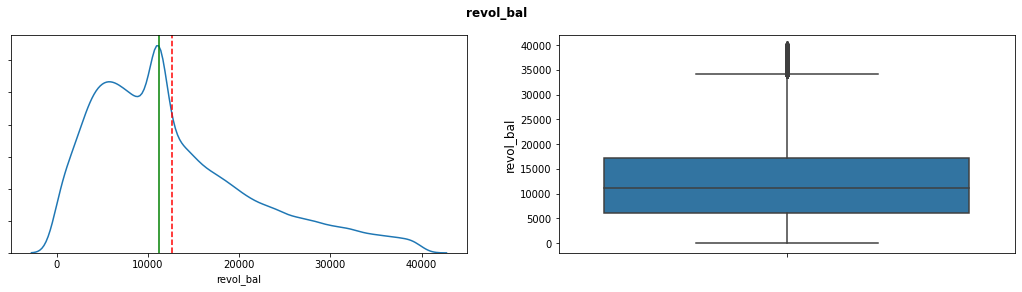

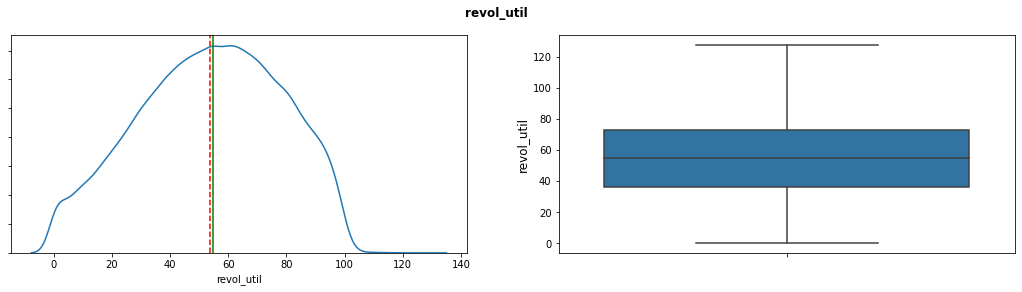

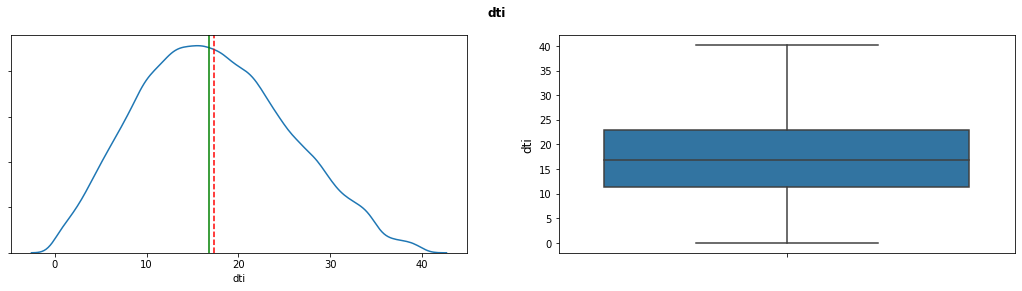

In [ ]:
for col in numerical_cols:
  fig, ax = plt.subplots(1, 2, figsize = (18, 4))
  plt.suptitle(col, fontsize = fontsize, fontweight = fontweight)
  kdeplot(X_test, col, None, ax[0])
  boxplot(X_test, col, None, ax[1])

### **Inference**

<ul>
<li>As we can see from the above plots, the test data is free from outliers from all the important and required numerical features
</ul>

## **Scaling**

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
model.coef_

array([[ 3.92027492e-06,  2.38450169e-03,  3.13336946e-02,
         1.36343532e-03, -1.11341373e-05,  2.93128096e-02,
         7.36526068e-03,  3.27711536e-04, -2.28339979e-05,
         7.05269238e-03,  1.07973181e-03, -1.14878672e-03,
         1.59096577e-04, -1.24130179e-03, -2.48741728e-04,
        -2.62451830e-04, -3.87834502e-04, -4.07601316e-04,
        -3.59028528e-04, -4.39201403e-04, -4.47041184e-04,
        -3.51524933e-04, -2.11690711e-04, -1.21331784e-04,
        -3.77263551e-06,  7.23823617e-05,  1.46028631e-04,
         1.68971599e-04,  2.37424191e-04,  2.47491545e-04,
         2.25986823e-04,  2.92924781e-04,  2.40651403e-04,
         2.28703641e-04,  2.54047492e-04,  2.41179878e-04,
         2.17116447e-04,  2.03340694e-04,  1.14840882e-04,
         1.24879209e-04,  1.15431672e-04,  1.13821520e-04,
         8.53468601e-05,  5.49729790e-05,  4.51810488e-05,
         3.92897738e-05,  1.75387242e-05,  2.36810552e-05,
        -1.62388372e-06,  5.95052082e-05,  1.05824901e-0

In [ ]:
model.intercept_

array([-5.12549746e-06])

### **Inference**

<ul>
<li>The model intercept is very close to zero , which means , our model has very less noise.
</ul>

## **Model 1**

### **Hyperparamter Tuning - Identify Best Lambda**

In [ ]:
train_scores = []
val_scores = []
scaler = StandardScaler()

for la in np.arange(0.01, 100.0, 5):
    scaled_lr = make_pipeline(scaler, LogisticRegression(C=1/la))
    scaled_lr.fit(X_train, y_train)
    train_score = scaled_lr.score(X_train, y_train)
    val_score = scaled_lr.score(X_val, y_val)
    train_scores.append(train_score)
    val_scores.append(val_score)

In [ ]:
len(val_scores)

20

### **Scoring and confusion matrix**

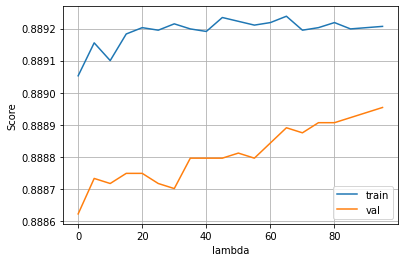

In [ ]:
plt.figure()
plt.plot(list(np.arange(0.01, 100.0, 5)), train_scores, label="train")
plt.plot(list(np.arange(0.01, 100.0, 5)), val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("lambda")
plt.ylabel("Score")
plt.grid()
plt.show()

In [ ]:
np.argmax(val_scores),val_scores[np.argmax(val_scores)]

(19, 0.8889539021111726)

In [ ]:
l_best = 0.01+5*np.argmax(val_scores)
l_best

10.01

In [ ]:
scaled_lr = make_pipeline( scaler, LogisticRegression(C=1/l_best))
scaled_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.028563267637817767))])

In [ ]:
test_score = scaled_lr.score(X_test, y_test)
print(test_score)

y_pred = scaled_lr.predict(X_test)

0.8895678356358484


In [ ]:
print(f"Accuracy : {accuracy_score(y_test, y_pred)*100}%")
print(f"recall_score : {recall_score(y_test, y_pred)*100}%")
print(f"precision_score : {precision_score(y_test, y_pred)*100}%")
print(f"f1_score : {f1_score(y_test, y_pred)*100}%")
print(f"AUC score : {metrics.roc_auc_score( y_test, y_pred)*100}%")
print(f"confusion_matrix :")
print(confusion_matrix(y_test, y_pred))

Accuracy : 88.95678356358484%
recall_score : 46.299161831076724%
precision_score : 94.72365123334653%
f1_score : 62.19739292364991%
AUC score : 72.83478883570709%
confusion_matrix :
[[63134   400]
 [ 8329  7181]]


In [ ]:
confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

### **Calculate the sensitivity**

In [ ]:
TP/(TP+FN)

0.46299161831076724

### **Calculate the specificity**

In [ ]:
# Calculate the specificity
TN/(TN+FP)

0.9937041584033746

### **Classification Report**

In [ ]:
print(f"{classification_report(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     63534
           1       0.95      0.46      0.62     15510

    accuracy                           0.89     79044
   macro avg       0.92      0.73      0.78     79044
weighted avg       0.90      0.89      0.87     79044



### **ROC AUC curve**

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred, drop_intermediate = False )

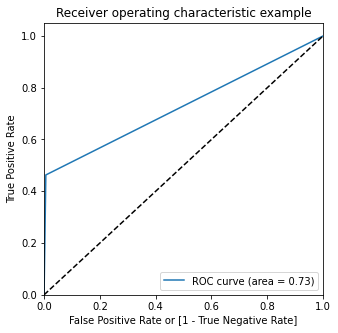

In [ ]:
draw_roc(y_test, y_pred)

### **Precision Recall Curve**

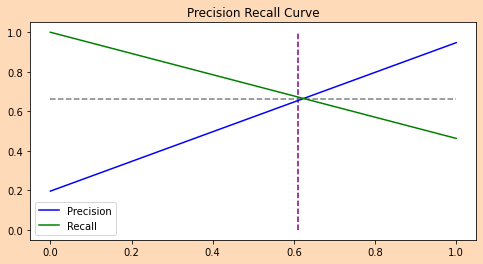

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_pred)

fig = plt.figure(figsize = (8,4))
fig.set_facecolor("peachpuff")

# Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, precision[:-1], "b",label='Precision')
plt.plot(thresholds, recall[:-1], "g",label='Recall')
plt.vlines(x=0.61,ymax=1,ymin=0.0,color="purple",linestyles="--")
plt.hlines(y=0.66,xmax=1,xmin=0.0,color="grey",linestyles="--")
plt.title('Precision Recall Curve')
plt.legend()
plt.show()

### **Inference**

<ul>
<li>Defaulters Business or Customers: 
<ul><li>For our simplest model 1 , we are getting fi-score as 62 % to check if the credit line can be extended to the business/customers who have a higher chances of defaulting/ not repaying the loan/credit taken. 
<li>Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone.
</ul>
<li>Non-Defaulters Business or Customers :
<ul><li>For our simplest model 1, we are getting fi-score as 94 % to check if the credit line can be extended to the business/customers who have a higher chances of fully repaying the loan/credit taken. 
<li>This is important as we can lose out on an opportunity to finance more supply chains and earn interest in it.
</ul>
</ul>

After the preprocessing and encoding steps, we had a total of 87 features and not all of these may be useful in forecasting. Alternatively we can select the top 5 or top 7 features, which had a major contribution in forecasting.

The idea is to have a less complex model without compromising on the overall model performance.

## **Model 2**

### **Fixing the imbalance issue in target feature**

<ul>
<li>Here we will give class weights manually for 0 (Fully paid):0.2, 1 (Charged off) :0.8
<li>We will also change the range of lambda to see any effect.
</ul>

In [ ]:
loantap_data['loan_status'].value_counts(normalize = True)*100

0    80.384799
1    19.615201
Name: loan_status, dtype: float64

### **Hyperparameter Tuning - Identify Best Lambda and assign class weights manually** *italicized text*

In [ ]:
train_scores = []
val_scores = []
scaler = StandardScaler()

for la in np.arange(0.01, 100.0, 2):
    scaled_lr = make_pipeline(scaler, LogisticRegression(C=1/la, class_weight={ 0:0.2, 1:0.8 }))
    scaled_lr.fit(X_train, y_train)
    train_score = scaled_lr.score(X_train, y_train)
    val_score = scaled_lr.score(X_val, y_val)
    train_scores.append(train_score)
    val_scores.append(val_score)

In [ ]:
len(val_scores)

50

### **Scoring and confusion matrix**

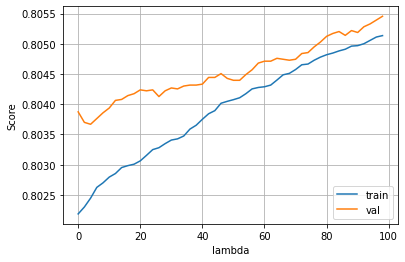

In [ ]:
plt.figure()
plt.plot(list(np.arange(0.01, 100.0, 2)), train_scores, label="train")
plt.plot(list(np.arange(0.01, 100.0, 2)), val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("lambda")
plt.ylabel("Score")
plt.grid()
plt.show()

In [ ]:
np.argmax(val_scores), val_scores[np.argmax(val_scores)]

(49, 0.8054558393294853)

In [ ]:
l_best = 0.01+2*np.argmax(val_scores)
l_best

98.01

In [ ]:
scaled_lr = make_pipeline( scaler, LogisticRegression(C=1/l_best))
scaled_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.010203040506070809))])

In [ ]:
test_score = scaled_lr.score(X_test, y_test)
print(test_score)

y_pred = scaled_lr.predict(X_test)

0.8896057891807094


In [ ]:
print(f"Accuracy : {accuracy_score(y_test, y_pred)*100}%")
print(f"recall_score : {recall_score(y_test, y_pred)*100}%")
print(f"precision_score : {precision_score(y_test, y_pred)*100}%")
print(f"f1_score : {f1_score(y_test, y_pred)*100}%")
print(f"AUC score : {metrics.roc_auc_score( y_test, y_pred)*100}%")
print(f"confusion_matrix :")
print(confusion_matrix(y_test, y_pred))

Accuracy : 88.96057891807094%
recall_score : 46.13797549967762%
precision_score : 95.05844845908608%
f1_score : 62.12344821599096%
AUC score : 72.77623111559573%
confusion_matrix :
[[63162   372]
 [ 8354  7156]]


In [ ]:
confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

### **Calculate the sensitivity**

In [ ]:
TP/(TP+FN)

0.46137975499677625

### **Calculate the specificity**

In [ ]:
# Calculate the specificity
TN/(TN+FP)

0.9941448673151384

### **Classification Report**

In [ ]:
print(f"{classification_report(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     63534
           1       0.95      0.46      0.62     15510

    accuracy                           0.89     79044
   macro avg       0.92      0.73      0.78     79044
weighted avg       0.90      0.89      0.87     79044



### **ROC AUC curve**

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred, drop_intermediate = False )

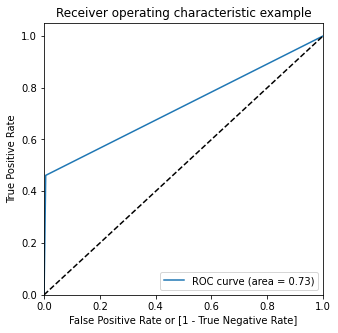

In [ ]:
draw_roc(y_test, y_pred)

### **Precision Recall Curve**

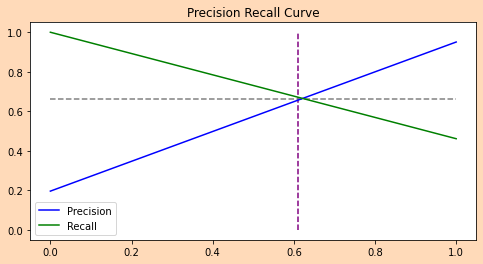

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_pred)

fig = plt.figure(figsize = (8,4))
fig.set_facecolor("peachpuff")

# Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, precision[:-1], "b",label='Precision')
plt.plot(thresholds, recall[:-1], "g",label='Recall')
plt.vlines(x=0.61,ymax=1,ymin=0.0,color="purple",linestyles="--")
plt.hlines(y=0.66,xmax=1,xmin=0.0,color="grey",linestyles="--")
plt.title('Precision Recall Curve')
plt.legend()
plt.show()

### **Inference**

<ul>
Defaulters Business or Customers: 
<ul><li>For our model 2 ( with balancing weights) , we are getting fi-score as 62 % to check if the credit line can be extended to the business/customers who have a higher chances of defaulting/ not repaying the loan/credit taken. 
<li>Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone.
</ul>
Honest Business or Customers :
<ul><li>For our model 2 ( with balancing weights) , we are getting fi-score as 94 % to check if the credit line can be extended to the business/customers who have a higher chances of fully repaying the loan/credit taken. 
<li>This is important as we can lose out on an opportunity to finance more supply chains and earn interest in it.
</ul>
</ul>

## **Model 3**

### **Identify the important features using RFE**

<ul>
we will select only the features which are important for our models using RFE (Recursive Feature Elimination)
</ul>

In [ ]:
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
lr3 = Pipeline(steps=[('imputer',imputer),
                              ('scaler',scaler),
                              ('logistic_model',LogisticRegression())
                             ])
type(lr3)

sklearn.pipeline.Pipeline

### **Recursive Feature Elimination**

In [ ]:
rfe = RFE(lr3['logistic_model'], n_features_to_select=20)

In [ ]:
rfe = rfe.fit(X_train, y_train)

In [ ]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('loan_amnt', False, 63),
 ('term', False, 18),
 ('int_rate', False, 41),
 ('installment', False, 58),
 ('annual_inc', False, 61),
 ('dti', False, 48),
 ('open_acc', False, 51),
 ('pub_rec', False, 28),
 ('revol_bal', False, 59),
 ('revol_util', False, 55),
 ('total_acc', False, 54),
 ('mort_acc', False, 22),
 ('pub_rec_bankruptcies', False, 27),
 ('earliest_cr_year', False, 56),
 ('A2', True, 1),
 ('A3', True, 1),
 ('A4', True, 1),
 ('A5', True, 1),
 ('B1', False, 8),
 ('B2', False, 7),
 ('B3', False, 10),
 ('B4', False, 25),
 ('B5', False, 26),
 ('C1', False, 40),
 ('C2', False, 62),
 ('C3', False, 42),
 ('C4', False, 21),
 ('C5', False, 20),
 ('D1', False, 17),
 ('D2', False, 16),
 ('D3', False, 15),
 ('D4', False, 13),
 ('D5', False, 14),
 ('E1', False, 11),
 ('E2', False, 9),
 ('E3', False, 5),
 ('E4', False, 6),
 ('E5', False, 4),
 ('F1', False, 47),
 ('F2', False, 2),
 ('F3', True, 1),
 ('F4', True, 1),
 ('F5', True, 1),
 ('G1', True, 1),
 ('G2', True, 1),
 ('G3', True, 1),
 ('

In [ ]:
new_col = X_train.columns[rfe.support_]
X_train = X_train[new_col]
X_val = X_val[new_col]
X_test = X_test[new_col]

### **Hyperparamter Tuning - Identify Best Lambda**

In [ ]:
train_scores = []
val_scores = []
scaler = StandardScaler()

for la in np.arange(0.01, 10000.0,500):
    scaled_lr = make_pipeline(scaler, LogisticRegression(C=1/la))
    scaled_lr.fit(X_train, y_train)
    train_score = scaled_lr.score(X_train, y_train)
    val_score = scaled_lr.score(X_val, y_val)
    train_scores.append(train_score)
    val_scores.append(val_score)

In [ ]:
len(val_scores)

20

### **Scoring and confusion matrix**

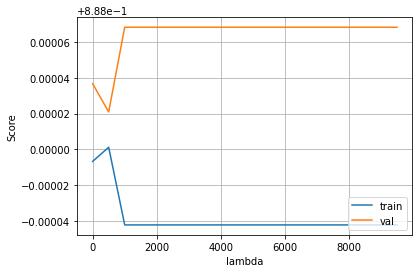

In [ ]:
plt.figure()
plt.plot(list(np.arange(0.01, 10000.0,500)), train_scores, label="train")
plt.plot(list(np.arange(0.01, 10000.0,500)), val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("lambda")
plt.ylabel("Score")
plt.grid()
plt.show()

In [ ]:
np.argmax(val_scores), val_scores[np.argmax(val_scores)]

(2, 0.8880683165968214)

In [ ]:
l_best = 0.01+500*np.argmax(val_scores)
l_best

1000.01

In [ ]:
scaled_lr = make_pipeline( scaler, LogisticRegression(C=1/l_best))
scaled_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=100.0))])

In [ ]:
test_score = scaled_lr.score(X_test, y_test)
print(test_score)

y_pred = scaled_lr.predict(X_test)

0.8884545316532564


In [ ]:
print(f"Accuracy : {accuracy_score(y_test, y_pred)*100}%")
print(f"recall_score : {recall_score(y_test, y_pred)*100}%")
print(f"precision_score : {precision_score(y_test, y_pred)*100}%")
print(f"f1_score : {f1_score(y_test, y_pred)*100}%")
print(f"AUC score : {metrics.roc_auc_score( y_test, y_pred)*100}%")
print(f"confusion_matrix :")
print(confusion_matrix(y_test, y_pred))

Accuracy : 88.84545316532564%
recall_score : 43.37846550612508%
precision_score : 99.4824781901523%
f1_score : 60.41395411484757%
AUC score : 71.66168844607729%
confusion_matrix :
[[63499    35]
 [ 8782  6728]]


In [ ]:
confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

### **Calculate the sensitivity**

In [ ]:
TP/(TP+FN)

0.4337846550612508

### **Calculate the specificity**

In [ ]:
# Calculate the specificity
TN/(TN+FP)

0.9994491138602952

### **Classification Report**

In [ ]:
print(f"{classification_report(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     63534
           1       0.99      0.43      0.60     15510

    accuracy                           0.89     79044
   macro avg       0.94      0.72      0.77     79044
weighted avg       0.90      0.89      0.87     79044



### **ROC AUC curve**

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_pred, drop_intermediate = False )

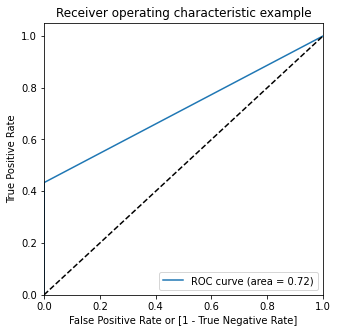

In [ ]:
draw_roc(y_test, y_pred)

### **Precision Recall Curve**

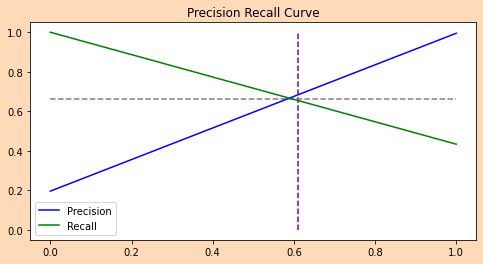

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_pred)

fig = plt.figure(figsize = (8,4))
fig.set_facecolor("peachpuff")

# Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, precision[:-1], "b",label='Precision')
plt.plot(thresholds, recall[:-1], "g",label='Recall')
plt.vlines(x=0.61,ymax=1,ymin=0.0,color="purple",linestyles="--")
plt.hlines(y=0.66,xmax=1,xmin=0.0,color="grey",linestyles="--")
plt.title('Precision Recall Curve')
plt.legend()
plt.show()

### **Inference**

<ul>
Defaulters Business or Customers: 
<ul><li>For our model 3 , we are getting fi-score as 60 % to check if the credit line can be extended to the business/customers who have a higher chances of defaulting/ not repaying the loan/credit taken. 
<li>Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone.
</ul>
Honest Business or Customers :
<ul><li>For our model 2 ( with balancing weights) , we are getting fi-score as 94 % to check if the credit line can be extended to the business/customers who have a higher chances of fully repaying the loan/credit taken. 
<li>This is important as we can lose out on an opportunity to finance more supply chains and earn interest in it.
</ul>
</ul>

## **Model 4**

Eliminating features based on VIF score and model building using stats model.

In [ ]:
X= loantap_data.drop(["loan_status"],axis =1)
y= loantap_data["loan_status"]

### **Splitting the data into train and test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

### **Missing value imputation on Train Data**

In [ ]:
missing_val = missingValue(X_train)
missing_val[missing_val['Total Missing'] > 0]

Total records =  276653


,Total Missing,In Percent
mort_acc,26015,9.4


At this point , we will do the missing value handling using median imputation for missing value for 'mort_acc'


In [ ]:
X_train['mort_acc'].value_counts()

0.0     97699
1.0     42294
2.0     34990
3.0     26817
4.0     19424
5.0     12679
6.0      7760
7.0      4253
8.0      2159
9.0      1151
10.0      571
11.0      331
12.0      178
13.0      105
14.0       75
15.0       44
16.0       27
17.0       16
18.0       15
20.0       10
19.0        9
24.0        9
22.0        6
25.0        3
21.0        2
27.0        2
31.0        2
23.0        2
32.0        2
30.0        1
28.0        1
26.0        1
Name: mort_acc, dtype: int64

In [ ]:
X_train['mort_acc'].median()

1.0

In [ ]:
X_train['mort_acc'] = X_train['mort_acc'].fillna(X_train['mort_acc'].median())

In [ ]:
missing_val = missingValue(X_train)
missing_val[missing_val['Total Missing'] > 0]

Total records =  276653


,Total Missing,In Percent


### **Feature Engineering - mort_acc**

In [ ]:
X_train['mort_acc'] = X_train['mort_acc'].apply(lambda x: 1 if x > 0.0 else 0)

### **Outlier treatment on Train Data**

In [ ]:
X_train_v1 = X_train.copy()
q1 = X_train_v1[numerical_cols].quantile(0.25)
q3 = X_train_v1[numerical_cols].quantile(0.75)
iqr = q3 -q1

X_train_v1 = X_train_v1[~((X_train_v1[numerical_cols]<q1-1.5*iqr) | (X_train_v1[numerical_cols]>q3+1.5*iqr)).any(axis = 1)]
X_train_v1 = X_train_v1.reset_index(drop = True)

In [ ]:
X_train.shape,X_train_v1.shape

((276653, 86), (238226, 86))

In [ ]:
X_train.shape[0]-X_train_v1.shape[0]

38427

In [ ]:
for i in numerical_cols:
    X_train[i] = np.where(X_train[i] > X_train[i].quantile(0.75) + (X_train[i].quantile(0.75) - X_train[i].quantile(0.25))*1.5,X_train[i].quantile(0.5),X_train[i])
    X_train[i] = np.where(X_train[i] < X_train[i].quantile(0.25) - (X_train[i].quantile(0.75) - X_train[i].quantile(0.25))*1.5, X_train[i].quantile(0.5),X_train[i])

### **Add a constant on Train Data**

In [ ]:
X_train_sm = sm.add_constant(X_train)

### **Fit a model**

In [ ]:
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:               276653
Model:                            GLM   Df Residuals:                   276566
Model Family:                Binomial   Df Model:                           86
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -70810.
Date:                Sun, 20 Nov 2022   Deviance:                   1.4162e+05
Time:                        01:00:16   Pearson chi2:                 1.58e+05
No. Iterations:                    30   Pseudo R-squ. (CS):             0.3798
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -26.6075   2.32e+04     -0.001      0.999   -4.54e+04    4.53e+04
loan_amnt                            2.775e-05   3.24e-06      8.566      0.000    2.14e-05    3.41e-05
term                                    0.4158      0.020     21.057      0.000       0.377       0.455
int_rate                               -0.0580      0.006    -10.179      0.000      -0.069      -0.047
installment                          7.782e-06   7.37e-05      0.106      0.916      -0.000       0.000
annual_inc                          -3.537e-06   4.58e-07     -7.716      0.000   -4.43e-06   -2.64e-06
dti                                     0.0240      0.001     25.516      0.000       0.022       0.026
open_acc                                0.0208      0.002     10.124      0.000       0.017       0.025
pub_rec                                 0.1811      0.036      5.054      0.000       0.111       0.251
revol_bal                           -6.594e-06      1e-06     -6.587      0.000   -8.56e-06   -4.63e-06
revol_util                              0.0034      0.000      9.880      0.000       0.003       0.004
total_acc                              -0.0068      0.001     -7.819      0.000      -0.009      -0.005
mort_acc                               -0.1351      0.018     -7.510      0.000      -0.170      -0.100
pub_rec_bankruptcies                   -0.1431      0.040     -3.589      0.000      -0.221      -0.065
earliest_cr_year                       -0.0033      0.001     -3.269      0.001      -0.005      -0.001
A2                                      0.4047      0.119      3.400      0.001       0.171       0.638
A3                                      0.5973      0.113      5.263      0.000       0.375       0.820
A4                                      0.7080      0.106      6.667      0.000       0.500       0.916
A5                                      0.9264      0.103      8.984      0.000       0.724       1.128
B1                                      1.1786      0.102     11.526      0.000       0.978       1.379
B2                                      1.2445      0.102     12.168      0.000       1.044       1.445
B3                                      1.3928      0.102     13.597      0.000       1.192       1.594
B4                                      1.5523      0.104     14.971      0.000       1.349       1.756
B5                                      1.6850      0.105     16.048      0.000       1.479       1.891
C1                                      1.8387      0.106     17.380      0.000       1.631       2.046
C2                                      1.9533      0.107     18.229      0.000       1.743       2.163
C3                                      2.1516      0.109     19.82

There are quite a few variables which have a p-value greater than 0.05. We will need to take care of them. But first, let's also look at the VIFs.

In [ ]:
X_train.drop(['installment','OTHER','application_type_INDIVIDUAL','initial_list_status_w','purpose_educational','purpose_wedding','05113',\
              '11650', '22690', '29597', '30723', '48052', '70466', '86630', '93700','Lower Loan'], axis = 1, inplace = True)

### **Refit the model with new set of features**

In [ ]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:               276653
Model:                            GLM   Df Residuals:                   276583
Model Family:                Binomial   Df Model:                           69
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2413e+05
Date:                Sun, 20 Nov 2022   Deviance:                   2.4827e+05
Time:                        01:00:33   Pearson chi2:                 2.77e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08808
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   2.5216      1.547      1.630      0.103      -0.510       5.553
loan_amnt                              2.4e-05    1.3e-06     18.452      0.000    2.15e-05    2.66e-05
term                                    0.3898      0.014     28.661      0.000       0.363       0.416
int_rate                               -0.0559      0.004    -13.197      0.000      -0.064      -0.048
annual_inc                          -3.831e-06   3.44e-07    -11.121      0.000   -4.51e-06   -3.16e-06
dti                                     0.0237      0.001     33.387      0.000       0.022       0.025
open_acc                                0.0221      0.002     14.285      0.000       0.019       0.025
pub_rec                                 0.2029      0.027      7.547      0.000       0.150       0.256
revol_bal                           -6.589e-06   7.56e-07     -8.711      0.000   -8.07e-06   -5.11e-06
revol_util                              0.0034      0.000     13.063      0.000       0.003       0.004
total_acc                              -0.0068      0.001    -10.418      0.000      -0.008      -0.006
mort_acc                               -0.1439      0.014    -10.654      0.000      -0.170      -0.117
pub_rec_bankruptcies                   -0.1743      0.030     -5.818      0.000      -0.233      -0.116
earliest_cr_year                       -0.0030      0.001     -3.896      0.000      -0.005      -0.001
A2                                      0.4306      0.092      4.706      0.000       0.251       0.610
A3                                      0.6160      0.087      7.053      0.000       0.445       0.787
A4                                      0.8266      0.081     10.248      0.000       0.669       0.985
A5                                      1.0122      0.079     12.846      0.000       0.858       1.167
B1                                      1.1936      0.078     15.228      0.000       1.040       1.347
B2                                      1.3125      0.078     16.774      0.000       1.159       1.466
B3                                      1.4715      0.078     18.798      0.000       1.318       1.625
B4                                      1.6132      0.079     20.360      0.000       1.458       1.768
B5                                      1.7776      0.080     22.185      0.000       1.621       1.935
C1                                      1.8793      0.081     23.264      0.000       1.721       2.038
C2                                      2.0572      0.082     25.190      0.000       1.897       2.217
C3                                      2.1749      0.083     26.282      0.000       2.013       2.337
C4                                      2.2573      0.084     26.91

There are still few variables which have a p-value greater than 0.05. We will repeat this process until we dont have any feature with p-value greated than 0.05

#### **VIF**

In [ ]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,int_rate,183.50
12,earliest_cr_year,173.30
53,purpose_debt_consolidation,37.54
3,annual_inc,21.94
66,Low,20.85
...,...,...
45,G4,1.14
46,G5,1.10
60,purpose_renewable_energy,1.05
68,Better off,1.04


In [ ]:
X_train.drop(['purpose_house','int_rate','earliest_cr_year',], axis = 1, inplace = True)

In [ ]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:               276653
Model:                            GLM   Df Residuals:                   276586
Model Family:                Binomial   Df Model:                           66
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2423e+05
Date:                Sun, 20 Nov 2022   Deviance:                   2.4846e+05
Time:                        01:07:09   Pearson chi2:                 2.77e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08747
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -3.7912      0.086    -43.954      0.000      -3.960      -3.622
loan_amnt                            2.397e-05    1.3e-06     18.436      0.000    2.14e-05    2.65e-05
term                                    0.3995      0.014     29.410      0.000       0.373       0.426
annual_inc                          -3.805e-06   3.45e-07    -11.043      0.000   -4.48e-06   -3.13e-06
dti                                     0.0243      0.001     34.340      0.000       0.023       0.026
open_acc                                0.0213      0.002     13.845      0.000       0.018       0.024
pub_rec                                 0.2237      0.027      8.337      0.000       0.171       0.276
revol_bal                           -6.438e-06   7.52e-07     -8.556      0.000   -7.91e-06   -4.96e-06
revol_util                              0.0031      0.000     11.961      0.000       0.003       0.004
total_acc                              -0.0065      0.001    -10.127      0.000      -0.008      -0.005
mort_acc                               -0.1206      0.013     -9.037      0.000      -0.147      -0.094
pub_rec_bankruptcies                   -0.1843      0.030     -6.156      0.000      -0.243      -0.126
A2                                      0.3932      0.091      4.299      0.000       0.214       0.572
A3                                      0.5353      0.087      6.144      0.000       0.365       0.706
A4                                      0.7242      0.080      9.018      0.000       0.567       0.882
A5                                      0.8652      0.078     11.089      0.000       0.712       1.018
B1                                      0.9985      0.077     12.963      0.000       0.848       1.149
B2                                      1.0609      0.076     13.967      0.000       0.912       1.210
B3                                      1.1683      0.075     15.589      0.000       1.021       1.315
B4                                      1.2643      0.075     16.894      0.000       1.118       1.411
B5                                      1.4004      0.075     18.666      0.000       1.253       1.547
C1                                      1.4664      0.075     19.641      0.000       1.320       1.613
C2                                      1.6112      0.075     21.606      0.000       1.465       1.757
C3                                      1.6964      0.075     22.731      0.000       1.550       1.843
C4                                      1.7459      0.075     23.379      0.000       1.600       1.892
C5                                      1.7966      0.075     23.964      0.000       1.650       1.943
D1                                      1.8963      0.075     25.20

There are still few variables which have a p-value greater than 0.05. We will repeat this process until we dont have any feature with p-value greated than 0.05

In [ ]:
X_train.drop(['purpose_renewable_energy'], axis = 1, inplace = True)

In [ ]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:               276653
Model:                            GLM   Df Residuals:                   276587
Model Family:                Binomial   Df Model:                           65
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2423e+05
Date:                Sun, 20 Nov 2022   Deviance:                   2.4846e+05
Time:                        01:07:23   Pearson chi2:                 2.77e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08745
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -3.7706      0.086    -43.939      0.000      -3.939      -3.602
loan_amnt                            2.394e-05    1.3e-06     18.415      0.000    2.14e-05    2.65e-05
term                                    0.3992      0.014     29.393      0.000       0.373       0.426
annual_inc                            -3.8e-06   3.45e-07    -11.031      0.000   -4.48e-06   -3.13e-06
dti                                     0.0243      0.001     34.338      0.000       0.023       0.026
open_acc                                0.0213      0.002     13.839      0.000       0.018       0.024
pub_rec                                 0.2239      0.027      8.343      0.000       0.171       0.276
revol_bal                           -6.424e-06   7.52e-07     -8.538      0.000    -7.9e-06   -4.95e-06
revol_util                              0.0031      0.000     11.967      0.000       0.003       0.004
total_acc                              -0.0065      0.001    -10.122      0.000      -0.008      -0.005
mort_acc                               -0.1208      0.013     -9.045      0.000      -0.147      -0.095
pub_rec_bankruptcies                   -0.1844      0.030     -6.159      0.000      -0.243      -0.126
A2                                      0.3932      0.091      4.299      0.000       0.214       0.572
A3                                      0.5353      0.087      6.144      0.000       0.365       0.706
A4                                      0.7242      0.080      9.018      0.000       0.567       0.882
A5                                      0.8652      0.078     11.088      0.000       0.712       1.018
B1                                      0.9986      0.077     12.965      0.000       0.848       1.150
B2                                      1.0609      0.076     13.967      0.000       0.912       1.210
B3                                      1.1683      0.075     15.590      0.000       1.021       1.315
B4                                      1.2644      0.075     16.896      0.000       1.118       1.411
B5                                      1.4005      0.075     18.668      0.000       1.253       1.548
C1                                      1.4664      0.075     19.641      0.000       1.320       1.613
C2                                      1.6115      0.075     21.610      0.000       1.465       1.758
C3                                      1.6966      0.075     22.734      0.000       1.550       1.843
C4                                      1.7462      0.075     23.383      0.000       1.600       1.893
C5                                      1.7969      0.075     23.969      0.000       1.650       1.944
D1                                      1.8965      0.075     25.20

In [ ]:
X_train.drop(['purpose_vacation'], axis = 1, inplace = True)

In [ ]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:               276653
Model:                            GLM   Df Residuals:                   276588
Model Family:                Binomial   Df Model:                           64
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2424e+05
Date:                Sun, 20 Nov 2022   Deviance:                   2.4847e+05
Time:                        01:07:36   Pearson chi2:                 2.77e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08742
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -3.7255      0.084    -44.398      0.000      -3.890      -3.561
loan_amnt                            2.377e-05    1.3e-06     18.309      0.000    2.12e-05    2.63e-05
term                                    0.3987      0.014     29.363      0.000       0.372       0.425
annual_inc                          -3.795e-06   3.45e-07    -11.015      0.000   -4.47e-06   -3.12e-06
dti                                     0.0243      0.001     34.381      0.000       0.023       0.026
open_acc                                0.0213      0.002     13.826      0.000       0.018       0.024
pub_rec                                 0.2236      0.027      8.333      0.000       0.171       0.276
revol_bal                           -6.397e-06   7.52e-07     -8.503      0.000   -7.87e-06   -4.92e-06
revol_util                              0.0031      0.000     11.969      0.000       0.003       0.004
total_acc                              -0.0065      0.001    -10.100      0.000      -0.008      -0.005
mort_acc                               -0.1213      0.013     -9.084      0.000      -0.147      -0.095
pub_rec_bankruptcies                   -0.1841      0.030     -6.148      0.000      -0.243      -0.125
A2                                      0.3932      0.091      4.299      0.000       0.214       0.572
A3                                      0.5355      0.087      6.147      0.000       0.365       0.706
A4                                      0.7246      0.080      9.023      0.000       0.567       0.882
A5                                      0.8659      0.078     11.097      0.000       0.713       1.019
B1                                      0.9992      0.077     12.973      0.000       0.848       1.150
B2                                      1.0616      0.076     13.976      0.000       0.913       1.210
B3                                      1.1690      0.075     15.599      0.000       1.022       1.316
B4                                      1.2651      0.075     16.906      0.000       1.118       1.412
B5                                      1.4015      0.075     18.680      0.000       1.254       1.549
C1                                      1.4676      0.075     19.658      0.000       1.321       1.614
C2                                      1.6126      0.075     21.624      0.000       1.466       1.759
C3                                      1.6979      0.075     22.751      0.000       1.552       1.844
C4                                      1.7476      0.075     23.403      0.000       1.601       1.894
C5                                      1.7983      0.075     23.989      0.000       1.651       1.945
D1                                      1.8982      0.075     25.23

In [ ]:
X_train.drop(['purpose_credit_card'], axis = 1, inplace = True)

In [ ]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:               276653
Model:                            GLM   Df Residuals:                   276589
Model Family:                Binomial   Df Model:                           63
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2424e+05
Date:                Sun, 20 Nov 2022   Deviance:                   2.4848e+05
Time:                        01:07:49   Pearson chi2:                 2.77e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08741
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -3.6599      0.079    -46.388      0.000      -3.815      -3.505
loan_amnt                            2.405e-05   1.29e-06     18.602      0.000    2.15e-05    2.66e-05
term                                    0.3994      0.014     29.419      0.000       0.373       0.426
annual_inc                          -3.808e-06   3.44e-07    -11.054      0.000   -4.48e-06   -3.13e-06
dti                                     0.0244      0.001     34.453      0.000       0.023       0.026
open_acc                                0.0214      0.002     13.900      0.000       0.018       0.024
pub_rec                                 0.2242      0.027      8.356      0.000       0.172       0.277
revol_bal                            -6.35e-06   7.52e-07     -8.445      0.000   -7.82e-06   -4.88e-06
revol_util                              0.0031      0.000     12.228      0.000       0.003       0.004
total_acc                              -0.0065      0.001    -10.088      0.000      -0.008      -0.005
mort_acc                               -0.1224      0.013     -9.178      0.000      -0.149      -0.096
pub_rec_bankruptcies                   -0.1833      0.030     -6.122      0.000      -0.242      -0.125
A2                                      0.3933      0.091      4.300      0.000       0.214       0.573
A3                                      0.5353      0.087      6.144      0.000       0.365       0.706
A4                                      0.7243      0.080      9.019      0.000       0.567       0.882
A5                                      0.8655      0.078     11.093      0.000       0.713       1.018
B1                                      0.9991      0.077     12.972      0.000       0.848       1.150
B2                                      1.0613      0.076     13.972      0.000       0.912       1.210
B3                                      1.1680      0.075     15.586      0.000       1.021       1.315
B4                                      1.2640      0.075     16.892      0.000       1.117       1.411
B5                                      1.4003      0.075     18.665      0.000       1.253       1.547
C1                                      1.4659      0.075     19.636      0.000       1.320       1.612
C2                                      1.6106      0.075     21.600      0.000       1.464       1.757
C3                                      1.6958      0.075     22.725      0.000       1.550       1.842
C4                                      1.7453      0.075     23.373      0.000       1.599       1.892
C5                                      1.7955      0.075     23.955      0.000       1.649       1.942
D1                                      1.8952      0.075     25.19

In [ ]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,annual_inc,21.48
60,Low,18.36
0,loan_amnt,16.46
4,open_acc,12.78
8,total_acc,11.50
...,...,...
54,purpose_moving,1.05
43,G4,1.04
62,Better off,1.04
44,G5,1.03


In [ ]:
X_train.drop(['purpose_major_purchase','purpose_moving','annual_inc','loan_amnt'], axis = 1, inplace = True)

In [ ]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:               276653
Model:                            GLM   Df Residuals:                   276593
Model Family:                Binomial   Df Model:                           59
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2446e+05
Date:                Sun, 20 Nov 2022   Deviance:                   2.4892e+05
Time:                        01:13:31   Pearson chi2:                 2.77e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08594
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -3.6180      0.078    -46.331      0.000      -3.771      -3.465
term                                    0.4665      0.013     35.826      0.000       0.441       0.492
dti                                     0.0248      0.001     35.235      0.000       0.023       0.026
open_acc                                0.0212      0.002     13.795      0.000       0.018       0.024
pub_rec                                 0.2157      0.027      8.051      0.000       0.163       0.268
revol_bal                           -4.477e-06   7.36e-07     -6.082      0.000   -5.92e-06   -3.03e-06
revol_util                              0.0029      0.000     11.412      0.000       0.002       0.003
total_acc                              -0.0066      0.001    -10.349      0.000      -0.008      -0.005
mort_acc                               -0.1303      0.013     -9.786      0.000      -0.156      -0.104
pub_rec_bankruptcies                   -0.1879      0.030     -6.286      0.000      -0.246      -0.129
A2                                      0.3914      0.091      4.281      0.000       0.212       0.571
A3                                      0.5374      0.087      6.169      0.000       0.367       0.708
A4                                      0.7324      0.080      9.123      0.000       0.575       0.890
A5                                      0.8709      0.078     11.165      0.000       0.718       1.024
B1                                      1.0046      0.077     13.047      0.000       0.854       1.156
B2                                      1.0672      0.076     14.054      0.000       0.918       1.216
B3                                      1.1720      0.075     15.644      0.000       1.025       1.319
B4                                      1.2680      0.075     16.951      0.000       1.121       1.415
B5                                      1.4023      0.075     18.699      0.000       1.255       1.549
C1                                      1.4674      0.075     19.664      0.000       1.321       1.614
C2                                      1.6096      0.075     21.595      0.000       1.463       1.756
C3                                      1.6968      0.075     22.749      0.000       1.551       1.843
C4                                      1.7480      0.075     23.421      0.000       1.602       1.894
C5                                      1.7974      0.075     23.992      0.000       1.651       1.944
D1                                      1.8976      0.075     25.242      0.000       1.750       2.045
D2                                      1.9232      0.076     25.440      0.000       1.775       2.071
D3                                      1.9564      0.076     25.72

In [ ]:
X_train.drop(['purpose_medical','purpose_other','Better off'], axis = 1, inplace = True)

In [ ]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:               276653
Model:                            GLM   Df Residuals:                   276596
Model Family:                Binomial   Df Model:                           56
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2447e+05
Date:                Sun, 20 Nov 2022   Deviance:                   2.4893e+05
Time:                        01:13:42   Pearson chi2:                 2.77e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08591
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -3.6185      0.078    -46.459      0.000      -3.771      -3.466
term                                    0.4645      0.013     35.809      0.000       0.439       0.490
dti                                     0.0249      0.001     35.481      0.000       0.024       0.026
open_acc                                0.0210      0.002     13.708      0.000       0.018       0.024
pub_rec                                 0.2149      0.027      8.023      0.000       0.162       0.267
revol_bal                           -4.529e-06   7.36e-07     -6.156      0.000   -5.97e-06   -3.09e-06
revol_util                              0.0028      0.000     11.281      0.000       0.002       0.003
total_acc                              -0.0067      0.001    -10.403      0.000      -0.008      -0.005
mort_acc                               -0.1302      0.013     -9.783      0.000      -0.156      -0.104
pub_rec_bankruptcies                   -0.1874      0.030     -6.273      0.000      -0.246      -0.129
A2                                      0.3921      0.091      4.288      0.000       0.213       0.571
A3                                      0.5385      0.087      6.182      0.000       0.368       0.709
A4                                      0.7342      0.080      9.145      0.000       0.577       0.892
A5                                      0.8722      0.078     11.182      0.000       0.719       1.025
B1                                      1.0062      0.077     13.068      0.000       0.855       1.157
B2                                      1.0692      0.076     14.081      0.000       0.920       1.218
B3                                      1.1744      0.075     15.679      0.000       1.028       1.321
B4                                      1.2709      0.075     16.993      0.000       1.124       1.417
B5                                      1.4054      0.075     18.745      0.000       1.258       1.552
C1                                      1.4709      0.075     19.717      0.000       1.325       1.617
C2                                      1.6133      0.075     21.654      0.000       1.467       1.759
C3                                      1.7010      0.075     22.816      0.000       1.555       1.847
C4                                      1.7525      0.075     23.494      0.000       1.606       1.899
C5                                      1.8022      0.075     24.071      0.000       1.655       1.949
D1                                      1.9024      0.075     25.324      0.000       1.755       2.050
D2                                      1.9288      0.076     25.536      0.000       1.781       2.077
D3                                      1.9625      0.076     25.83

In [ ]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif.head(10)

,Features,VIF
2,open_acc,12.73
6,total_acc,11.46
54,Low,11.37
5,revol_util,8.83
1,dti,7.55
53,Very Low,6.58
55,Average,5.15
4,revol_bal,4.98
3,pub_rec,4.83
8,pub_rec_bankruptcies,4.63


In [ ]:
X_train.drop(['open_acc','total_acc','Low','revol_util','dti','Very Low','Average'], axis = 1, inplace = True)

In [ ]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:               276653
Model:                            GLM   Df Residuals:                   276603
Model Family:                Binomial   Df Model:                           49
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2599e+05
Date:                Sun, 20 Nov 2022   Deviance:                   2.5199e+05
Time:                        01:17:27   Pearson chi2:                 2.77e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.07576
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -3.4910      0.073    -47.799      0.000      -3.634      -3.348
term                                    0.4130      0.013     32.628      0.000       0.388       0.438
pub_rec                                 0.1399      0.026      5.281      0.000       0.088       0.192
revol_bal                            2.327e-06   6.24e-07      3.728      0.000     1.1e-06    3.55e-06
mort_acc                               -0.2407      0.013    -18.703      0.000      -0.266      -0.215
pub_rec_bankruptcies                   -0.1458      0.030     -4.930      0.000      -0.204      -0.088
A2                                      0.4513      0.091      4.944      0.000       0.272       0.630
A3                                      0.6304      0.087      7.252      0.000       0.460       0.801
A4                                      0.8415      0.080     10.509      0.000       0.685       0.998
A5                                      0.9973      0.078     12.824      0.000       0.845       1.150
B1                                      1.1605      0.077     15.129      0.000       1.010       1.311
B2                                      1.2456      0.076     16.482      0.000       1.097       1.394
B3                                      1.3717      0.074     18.414      0.000       1.226       1.518
B4                                      1.4824      0.074     19.941      0.000       1.337       1.628
B5                                      1.6310      0.074     21.896      0.000       1.485       1.777
C1                                      1.7107      0.074     23.096      0.000       1.566       1.856
C2                                      1.8672      0.074     25.253      0.000       1.722       2.012
C3                                      1.9647      0.074     26.562      0.000       1.820       2.110
C4                                      2.0256      0.074     27.383      0.000       1.881       2.171
C5                                      2.0879      0.074     28.129      0.000       1.942       2.233
D1                                      2.2011      0.074     29.575      0.000       2.055       2.347
D2                                      2.2381      0.075     29.921      0.000       2.092       2.385
D3                                      2.2696      0.075     30.165      0.000       2.122       2.417
D4                                      2.3433      0.075     31.099      0.000       2.196       2.491
D5                                      2.3738      0.076     31.203      0.000       2.225       2.523
E1                                      2.4268      0.077     31.500      0.000       2.276       2.578
E2                                      2.5471      0.077     33.00

In [ ]:
X_train.drop(['purpose_home_improvement'], axis = 1, inplace = True)

In [ ]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            loan_status   No. Observations:               276653
Model:                            GLM   Df Residuals:                   276604
Model Family:                Binomial   Df Model:                           48
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2599e+05
Date:                Sun, 20 Nov 2022   Deviance:                   2.5199e+05
Time:                        01:17:35   Pearson chi2:                 2.77e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.07574
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -3.4818      0.073    -47.787      0.000      -3.625      -3.339
term                                    0.4134      0.013     32.669      0.000       0.389       0.438
pub_rec                                 0.1406      0.026      5.309      0.000       0.089       0.193
revol_bal                            2.225e-06   6.22e-07      3.577      0.000    1.01e-06    3.44e-06
mort_acc                               -0.2404      0.013    -18.682      0.000      -0.266      -0.215
pub_rec_bankruptcies                   -0.1459      0.030     -4.933      0.000      -0.204      -0.088
A2                                      0.4506      0.091      4.936      0.000       0.272       0.629
A3                                      0.6296      0.087      7.243      0.000       0.459       0.800
A4                                      0.8408      0.080     10.501      0.000       0.684       0.998
A5                                      0.9966      0.078     12.816      0.000       0.844       1.149
B1                                      1.1598      0.077     15.120      0.000       1.009       1.310
B2                                      1.2448      0.076     16.472      0.000       1.097       1.393
B3                                      1.3712      0.074     18.407      0.000       1.225       1.517
B4                                      1.4818      0.074     19.932      0.000       1.336       1.627
B5                                      1.6303      0.074     21.886      0.000       1.484       1.776
C1                                      1.7102      0.074     23.088      0.000       1.565       1.855
C2                                      1.8665      0.074     25.245      0.000       1.722       2.011
C3                                      1.9641      0.074     26.555      0.000       1.819       2.109
C4                                      2.0251      0.074     27.377      0.000       1.880       2.170
C5                                      2.0874      0.074     28.123      0.000       1.942       2.233
D1                                      2.2005      0.074     29.568      0.000       2.055       2.346
D2                                      2.2376      0.075     29.914      0.000       2.091       2.384
D3                                      2.2689      0.075     30.156      0.000       2.121       2.416
D4                                      2.3427      0.075     31.091      0.000       2.195       2.490
D5                                      2.3731      0.076     31.194      0.000       2.224       2.522
E1                                      2.4263      0.077     31.494      0.000       2.275       2.577
E2                                      2.5466      0.077     33.00

In [ ]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif.head(10)

,Features,VIF
1,pub_rec,4.81
4,pub_rec_bankruptcies,4.61
3,mort_acc,3.98
2,revol_bal,3.52
40,RENT,2.61
44,purpose_debt_consolidation,2.51
42,verification_status_Verified,2.41
41,verification_status_Source Verified,2.17
0,term,1.88
11,B3,1.65


Now, both the p-values and VIFs seem decent enough for all the variables. So let's go ahead and make predictions using this final set of features.

### **Evaluation - Train Data**

In [ ]:
res = logm1.fit()
y_train_pred = res.predict(sm.add_constant(X_train))
y_train_pred

69562     0.111359
18239     0.071418
316733    0.205902
285026    0.185334
352685    0.151953
            ...   
340502    0.137426
254332    0.044873
211195    0.202321
56189     0.065135
301179    0.046197
Length: 276653, dtype: float64

In [ ]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred

array([0.11135864, 0.07141833, 0.20590193, ..., 0.20232073, 0.06513464,
       0.0461973 ])

In [ ]:
y_train_pred_final = pd.DataFrame({'Loan_Status':y_train.values, 'Loan_Status_Prob':y_train_pred})
y_train_pred_final.head()

,Loan_Status,Loan_Status_Prob
0,0,0.111359
1,0,0.071418
2,0,0.205902
3,1,0.185334
4,0,0.151953


In [ ]:
y_train_pred_final['Predicted'] = y_train_pred_final.Loan_Status_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()
y_train_pred_final.Loan_Status, y_train_pred_final.Predicted 

(0         0
 1         0
 2         0
 3         1
 4         0
          ..
 276648    0
 276649    0
 276650    0
 276651    0
 276652    0
 Name: Loan_Status, Length: 276653, dtype: int64, 0         0
 1         0
 2         0
 3         0
 4         0
          ..
 276648    0
 276649    0
 276650    0
 276651    0
 276652    0
 Name: Predicted, Length: 276653, dtype: int64)

#### **Scoring and confusion matrix**

In [ ]:
print(f"Accuracy : {accuracy_score(y_train_pred_final.Loan_Status, y_train_pred_final.Predicted )*100}%")
print(f"recall_score : {recall_score(y_train_pred_final.Loan_Status, y_train_pred_final.Predicted )*100}%")
print(f"precision_score : {precision_score(y_train_pred_final.Loan_Status, y_train_pred_final.Predicted )*100}%")
print(f"f1_score : {f1_score(y_train_pred_final.Loan_Status, y_train_pred_final.Predicted )*100}%")
print(f"AUC score : {metrics.roc_auc_score(y_train_pred_final.Loan_Status, y_train_pred_final.Predicted )*100}%")
print(f"confusion_matrix :")
print(confusion_matrix(y_train_pred_final.Loan_Status, y_train_pred_final.Predicted ))

Accuracy : 80.45096203547403%
recall_score : 2.6242992033048096%
precision_score : 52.60628465804067%
f1_score : 4.999209541709848%
AUC score : 51.023967754860834%
confusion_matrix :
[[221147   1282]
 [ 52801   1423]]


#### **ROC AUC curve**

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Loan_Status, y_train_pred_final.Predicted, drop_intermediate = False )

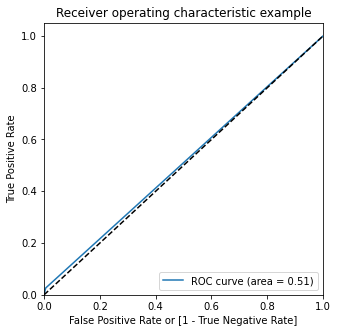

In [ ]:
draw_roc(y_train_pred_final.Loan_Status, y_train_pred_final.Predicted)

The area under the curve of the ROC is 0.51 which is not that good. Let's also check the sensitivity and specificity tradeoff to find the optimal cutoff point.
Let's create columns with different probability cutoffs 

In [ ]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Loan_Status_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Loan_Status,Loan_Status_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.111359,0,1,1,0,0,0,0,0,0,0,0
1,0,0.071418,0,1,0,0,0,0,0,0,0,0,0
2,0,0.205902,0,1,1,1,0,0,0,0,0,0,0
3,1,0.185334,0,1,1,0,0,0,0,0,0,0,0
4,0,0.151953,0,1,1,0,0,0,0,0,0,0,0


In [ ]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Loan_Status, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.196000  1.000000  0.000000
0.1   0.1  0.387189  0.920810  0.257102
0.2   0.2  0.637354  0.655042  0.633042
0.3   0.3  0.761445  0.353091  0.860994
0.4   0.4  0.799525  0.135198  0.961475
0.5   0.5  0.804510  0.026243  0.994236
0.6   0.6  0.804043  0.000553  0.999919
0.7   0.7  0.804000  0.000000  1.000000
0.8   0.8  0.804000  0.000000  1.000000
0.9   0.9  0.804000  0.000000  1.000000


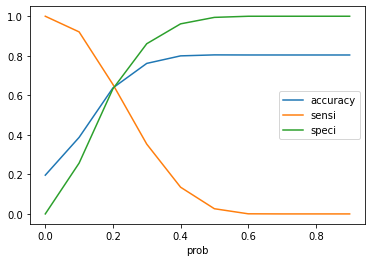

In [ ]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [ ]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Loan_Status_Prob.map( lambda x: 1 if x > 0.2 else 0)

y_train_pred_final.head()

,Loan_Status,Loan_Status_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.111359,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.071418,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.205902,0,1,1,1,0,0,0,0,0,0,0,1
3,1,0.185334,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.151953,0,1,1,0,0,0,0,0,0,0,0,0


In [ ]:
print(f"Accuracy : {accuracy_score(y_train_pred_final.Loan_Status, y_train_pred_final.final_predicted )*100}%")
print(f"recall_score : {recall_score(y_train_pred_final.Loan_Status, y_train_pred_final.final_predicted )*100}%")
print(f"precision_score : {precision_score(y_train_pred_final.Loan_Status, y_train_pred_final.final_predicted )*100}%")
print(f"f1_score : {f1_score(y_train_pred_final.Loan_Status, y_train_pred_final.final_predicted )*100}%")
print(f"AUC score : {metrics.roc_auc_score(y_train_pred_final.Loan_Status, y_train_pred_final.final_predicted )*100}%")
print(f"confusion_matrix :")
print(confusion_matrix(y_train_pred_final.Loan_Status, y_train_pred_final.final_predicted ))

Accuracy : 63.7354375336613%
recall_score : 65.50420478017114%
precision_score : 30.321578268923776%
f1_score : 41.45420593470078%
AUC score : 64.40422508991338%
confusion_matrix :
[[140807  81622]
 [ 18705  35519]]


### **Evaluation - Test Data**

In [ ]:
X_train.columns

Index(['term', 'pub_rec', 'revol_bal', 'mort_acc', 'pub_rec_bankruptcies',
       'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3',
       'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5',
       'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5', 'OWN',
       'RENT', 'verification_status_Source Verified',
       'verification_status_Verified', 'application_type_JOINT',
       'purpose_debt_consolidation', 'purpose_small_business', 'Average Loan',
       'High Loan'],
      dtype='object')

In [ ]:
X_test.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies', 'earliest_cr_year', 'A2', 'A3',
       'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5',
       'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2',
       'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5', 'OTHER', 'OWN', 'RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_INDIVIDUAL', 'application_type_JOINT',
       'initial_list_status_w', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', '05113', '11650', '22690',
       '2959

In [ ]:
set(X_test.columns) - set(X_train.columns)

{'05113',
 '11650',
 '22690',
 '29597',
 '30723',
 '48052',
 '70466',
 '86630',
 '93700',
 'Average',
 'Better off',
 'Low',
 'Lower Loan',
 'OTHER',
 'Very Low',
 'annual_inc',
 'application_type_INDIVIDUAL',
 'dti',
 'earliest_cr_year',
 'initial_list_status_w',
 'installment',
 'int_rate',
 'loan_amnt',
 'open_acc',
 'purpose_credit_card',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_vacation',
 'purpose_wedding',
 'revol_util',
 'total_acc'}

In [ ]:
X_test.drop(['05113',
 '11650',
 '22690',
 '29597',
 '30723',
 '48052',
 '70466',
 '86630',
 '93700',
 'Average',
 'Better off',
 'Low',
 'Lower Loan',
 'OTHER',
 'Very Low',
 'annual_inc',
 'application_type_INDIVIDUAL',
 'dti',
 'earliest_cr_year',
 'initial_list_status_w',
 'installment',
 'int_rate',
 'loan_amnt',
 'open_acc',
 'purpose_credit_card',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_vacation',
 'purpose_wedding',
 'revol_util',
 'total_acc'], axis = 1, inplace = True)

In [ ]:
col = X_test.columns
col

Index(['term', 'pub_rec', 'revol_bal', 'mort_acc', 'pub_rec_bankruptcies',
       'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3',
       'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5',
       'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5', 'OWN',
       'RENT', 'verification_status_Source Verified',
       'verification_status_Verified', 'application_type_JOINT',
       'purpose_debt_consolidation', 'purpose_small_business', 'Average Loan',
       'High Loan'],
      dtype='object')

In [ ]:
X_test_sm = sm.add_constant(X_test[col])

In [ ]:
X_test_sm

,const,term,pub_rec,revol_bal,mort_acc,pub_rec_bankruptcies,A2,A3,A4,A5,...,G5,OWN,RENT,verification_status_Source Verified,verification_status_Verified,application_type_JOINT,purpose_debt_consolidation,purpose_small_business,Average Loan,High Loan
346397,1.0,0,0,24499.0,3.0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
78418,1.0,0,1,8381.0,0.0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
356956,1.0,0,0,7721.0,NaN,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
327009,1.0,0,0,44810.0,5.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
124321,1.0,0,0,4901.0,NaN,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139477,1.0,0,0,10425.0,3.0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
371079,1.0,0,0,2298.0,NaN,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
303152,1.0,0,0,8966.0,3.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
108628,1.0,0,0,51680.0,3.0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0


In [ ]:
y_test_pred = res.predict(sm.add_constant(X_test))

In [ ]:
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1

,0
346397,0.152264
78418,0.195656
356956,NaN
327009,0.040273
124321,NaN
...,...
139477,0.046190
371079,NaN
303152,0.049438
108628,0.094881


In [ ]:
y_test_df = pd.DataFrame(y_test)
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final= y_pred_final.rename(columns = {0 : 'Loan_Status_Prob'})
y_pred_final['final_predicted'] = y_pred_final.Loan_Status_Prob.map(lambda x: 1 if x > 0.2 else 0)

#### **Scoring and confusion matrix**

In [ ]:
metrics.accuracy_score(y_pred_final['loan_status'], y_pred_final.final_predicted)

0.6973078285511867

In [ ]:
print(f"Accuracy : {accuracy_score(y_pred_final['loan_status'],  y_pred_final.final_predicted )*100}%")
print(f"recall_score : {recall_score(y_pred_final['loan_status'],  y_pred_final.final_predicted )*100}%")
print(f"precision_score : {precision_score(y_pred_final['loan_status'],  y_pred_final.final_predicted )*100}%")
print(f"f1_score : {f1_score(y_pred_final['loan_status'],  y_pred_final.final_predicted )*100}%")
print(f"AUC score : {metrics.roc_auc_score(y_pred_final['loan_status'], y_pred_final.final_predicted )*100}%")
print(f"confusion_matrix :")
print(confusion_matrix(y_pred_final['loan_status'],  y_pred_final.final_predicted))

Accuracy : 69.73078285511866%
recall_score : 51.693205716983556%
precision_score : 32.83712307105077%
f1_score : 40.162062123814124%
AUC score : 62.91767678755431%
confusion_matrix :
[[70633 24634]
 [11255 12044]]


In [ ]:
print(f"{classification_report(y_pred_final['loan_status'], y_pred_final.final_predicted )}")

              precision    recall  f1-score   support

           0       0.86      0.74      0.80     95267
           1       0.33      0.52      0.40     23299

    accuracy                           0.70    118566
   macro avg       0.60      0.63      0.60    118566
weighted avg       0.76      0.70      0.72    118566



### **Inference**

<ul>
Defaulters Business or Customers: 
<ul><li> For our model 4 , we are getting fi-score as 40% to check if the credit line can be extended to the business/customers who have a higher chances of defaulting/ not repaying the loan/credit taken. Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone.
</ul>
Honest Business or Customers :
<ul><li>For our model 4 ( with balancing weights) , we are getting fi-score as 80% to check if the credit line can be extended to the business/customers who have a higher chances of fully repaying the loan/credit taken. This is important as we can lose out on an opportunity to finance more supply chains and earn interest in it.
We can conclude from the above metrics and f1-score that the Model 4 is the worst performer amongst all the 4 models in terms of Precision and Recal but it's have a best Recall score of 74%.
</ul>
</ul>

# **Questionnaire**

<ol>
<li>What percentage of customers have fully paid their Loan Amount?
- **80% of the customers have fully paid their Loan Amount**
<li>Comment about the correlation between Loan Amount and Installment features.
<ul>
<li>loan_amnt and installment are highly correlated which means number of installments are more when the loan amount is more.
<li>But as loan amount increases, the installments owed by the defaulters decreases as compared to the installments by the honest borrowers who are not defaulting.
</ul>
<li>The majority of people have home ownership as MORTGAGE
<li>People with grades ‘A’ are more likely to fully pay their loan. (T/F) - T
<li>Name the top 2 afforded job titles.
<ul>
<li>Teacher
<li>Manager
</ul>
<li>Thinking from a bank's perspective, which metric should our primary focus be on..
ROC AUC, Precision, Recall, F1 Score
<ul>
<li>If thinking purely in terms of not loosing money in bad loans, Recall is the parameter which should be more focused. In Model 4, recall is 65 % which is comparatively higher than the other three Models. 

<li>If we think in terms of not loosing customers at the cost of loosing some money in bad loans, Precision should be the main parameter that we should focus. Our three models ( 1,2,3), Model 3 to be specific has highest precision percentage i.e nearly equal to 100 %

<li>But we have to provide a balanced stance, then F1 score is the metric as it considers both Precision and Recall (harmonically). Model 2 has the highest F1 core.

<li>In order to conclude, since Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone. And hence Model 4 is the best model which is having **highest Recall percentage.**
</ul>
<li>How does the gap in precision and recall affect the bank?
<ul><li>The gap in precision and recall affects the Lending Clubs/Banks in terms if more difference in precision and recall, more are the chances of Lending Clubs/Banks loosing money in form of bad loans. 
<li>In Model 4 we are getting less precision core than the recall score and the difference is of 15. Whereas in all other models the difference between Precision and Recall is around 50 % ( Precision being the highest and recall being in range of 40-50 %. This clearly shows that there's a risk of Lending Clubs/Banks giving bad loans to defaulters and thus the NPA of the Lending Clubs/Banks are currently rising.</ul>
<li>Which were the features that heavily affected the outcome?
<ul><li>Term (36 or 60 months) , Subgrades ( A, B ,F5 and G) , application_type_joint , mort_acc and any of the two -pub_rec_bankruptcies or pub_rec .
<li>These are the top 5 features which are heavily affecting the outcome and are primarily important.
</ul>
<li>Will the results be affected by geographical location? (Yes/No) 
<ul>
<li>Yes, there are few Geographical locations based on zip codes where the charged off rates are 100 % . Hence the results are affected by geographical location

# **Tradeoff Questions**

<ol>
<li>How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.
<ul>
<li>As we have seen in our first two models, by keeping precion score higher and then assigning priority to fi score and then recall, we can make sure that real defaulters ( TP ) and low False positives ( FP ) in denominator of Precision. This is important as we can lose out on an opportunity to finance more supply chains and earn interest in it.
<li>Also, we have to handle treat missing values and outliers after train test split. Missing values can be treated on all three types of data (train, cv and test but outliers needs to get handled only on train data).
<li>Even, proper balancing of class weights and finding best hyperparameter can be though as one of the key consideration. 
</ul>
<li>Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone
<ul>
<li>Recall rate should be low
<li>Then the priority should be considering less gap between precison and recall and having a more AUC (area under the curve score)
</ol>
